In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
from tqdm import tqdm

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import data_quality_checks

In [4]:
def cogs_analysis(df_in:pd.DataFrame,df_sales:pd.DataFrame,freq: str) -> Tuple[pd.DataFrame,pd.DataFrame]:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")
    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")
        df_sales['week'] = df_sales['sales_datetime'].dt.strftime("%W")
    # total # of trxns
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)

    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]

    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxn by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    df_cogs_null = df_cogs_average_product[df_cogs_average_product['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[df_cogs_null['per_unit_product'].notnull()]
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','count_incoming', 'coverage']]
    
    return df_summary_simp,df_cogs_average_product




In [5]:
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'
#CURRENT_MONTH = '2022-02'

In [6]:
ca_df = pd.read_csv('all_retailer_company.csv',index_col = 0)
ca_df.columns = ['company_name','company_identifier','state','licenses']
ca_df['company_identifier'] = ca_df['company_identifier'].astype(str)

In [7]:
ca_df_clean = ca_df[~ca_df['company_identifier'].isin(['PL','WHT','GF','UR'])]
ca_df_clean.shape

(62, 4)

In [8]:
len(ca_df_clean['company_identifier'].unique())

62

In [9]:
ca_df_clean['lic_list'] = [list(ca_df_clean['licenses'])[i].split(";") for i in range(len(ca_df_clean))]

In [10]:
ca_df_clean.head()

,company_name,company_identifier,state,licenses,lic_list
0,99 High Tide,99HT,CA,C10-0000279-LIC,[C10-0000279-LIC]
1,Altum LLC,ALT,MI,PC-000310;AU-R-000380,"[PC-000310, AU-R-000380]"
2,Bella Sol,BS,MI,PC-000185;AU-R-000156,"[PC-000185, AU-R-000156]"
3,Big Medicine Cannabissary,BMC,CO,402-00930,[402-00930]
4,Boston Bud Factory,BBF,MA,MR281525,[MR281525]


In [11]:
def read_df_in(COMPANY_IDENTIFIER,license_numbers):
    company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
    )
    company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
    return company_incoming_transfer_packages_dataframe


In [19]:
def read_df_sales(COMPANY_IDENTIFIER,license_numbers):
    query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
    )
    company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(query, engine)
    deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)
    deduped_sales_receipts_with_transactions_dataframe['sales_datetime'] = pd.to_datetime(deduped_sales_receipts_with_transactions_dataframe['sales_datetime'])
    deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')
    return deduped_sales_receipts_with_transactions_dataframe


In [41]:
def get_cogs_list(company_list,transfer_packages_start_date,sales_transactrions_start_date,map_df):
    cogs_df_list = {}
    for c in tqdm(company_list):
        df_summary_simp_list = {}
        print(c)
        l_list = map_df[map_df['company_identifier'] == c]['lic_list'].to_list()[0]
        for l in tqdm(l_list):
            print(l)
            df_in = read_df_in([c],[l])
            df_sales = read_df_sales([c],[l])
            df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
            df_in = df_in[df_in['per_unit_incoming'] <= 10000]
            df_summary_simp,df_cogs_average_product = cogs_analysis(df_in,df_sales,'monthly')
            df_summary_simp.index = df_summary_simp.date 
            # tax treatment
            df_summary_simp['revenue_after_tax'] = df_summary_simp['revenue'] * 1.15
            df_summary_simp['cogs_after_tax'] = df_summary_simp['cogs'] * 1.27
            df_summary_simp['margin_$_after_tax'] = df_summary_simp['revenue_after_tax'] - df_summary_simp['cogs_after_tax']
            df_summary_simp['margin_%_after_tax'] = df_summary_simp['margin_$_after_tax'] / df_summary_simp['revenue_after_tax']

            #rolling gm %
            df_summary_simp['gm_past_quarter_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(3).mean().values
            df_summary_simp['gm_past_2quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(6).mean().values
            df_summary_simp['gm_past_3quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(9).mean().values

            #rolling gm $
            df_summary_simp['gm$_past_quarter_after_tax'] = df_summary_simp[['margin_$_after_tax']].rolling(3).mean().values
            df_summary_simp['gm$_past_2quarters_after_tax'] = df_summary_simp[['margin_$_after_tax']].rolling(6).mean().values
            df_summary_simp['gm$_past_3quarters_after_tax'] = df_summary_simp[['margin_$_after_tax']].rolling(9).mean().values
            df_summary_simp_list[l] = df_summary_simp
        cogs_df_list[c] =  df_summary_simp_list
    return cogs_df_list

    

    

In [33]:
#list(ca_df_clean['company_identifier'])[0:3]

# cogs & coverage

In [43]:
a = get_cogs_list(list(ca_df_clean['company_identifier']),TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,ca_df_clean)

  0%|          | 0/62 [00:00<?, ?it/s]

99HT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000279-LIC



  2%|▏         | 1/62 [00:05<05:31,  5.44s/it]

ALT



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000310



 50%|█████     | 1/2 [00:02<00:02,  2.11s/it]

AU-R-000380



  3%|▎         | 2/62 [00:12<06:32,  6.54s/it]

BS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000185



 50%|█████     | 1/2 [00:02<00:02,  2.76s/it]

AU-R-000156



  5%|▍         | 3/62 [00:20<07:01,  7.15s/it]

BMC



  0%|          | 0/1 [00:00<?, ?it/s]

402-00930



  6%|▋         | 4/62 [00:27<06:58,  7.21s/it]

BBF



  0%|          | 0/1 [00:00<?, ?it/s]

MR281525



  8%|▊         | 5/62 [00:35<06:48,  7.16s/it]

BUD



  0%|          | 0/5 [00:00<?, ?it/s]

C9-0000464-LIC



 20%|██        | 1/5 [00:07<00:31,  7.94s/it]

C9-0000467-LIC



 40%|████      | 2/5 [00:15<00:22,  7.56s/it]

C9-0000444-LIC



 60%|██████    | 3/5 [00:22<00:14,  7.20s/it]

C9-0000167-LIC



 80%|████████  | 4/5 [00:33<00:08,  8.92s/it]

C9-0000399-LIC



 10%|▉         | 6/62 [01:17<17:48, 19.09s/it]

CHO



  0%|          | 0/1 [00:00<?, ?it/s]

AU-R-000575



 11%|█▏        | 7/62 [01:22<13:28, 14.70s/it]

CG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000157-LIC



 13%|█▎        | 8/62 [01:29<11:00, 12.23s/it]

CPA



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000461-LIC



 50%|█████     | 1/2 [00:18<00:18, 18.37s/it]

C9-0000348-LIC



 15%|█▍        | 9/62 [01:58<15:13, 17.23s/it]

CPC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000056-LIC



 16%|█▌        | 10/62 [02:06<12:33, 14.49s/it]

CSC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000670-LIC



 50%|█████     | 1/2 [00:15<00:15, 15.76s/it]

C10-0000918-LIC



 18%|█▊        | 11/62 [02:28<14:20, 16.86s/it]

CCC



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000087-LIC



 19%|█▉        | 12/62 [02:47<14:38, 17.56s/it]

CC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000758-LIC



 21%|██        | 13/62 [02:55<11:46, 14.43s/it]

DWF



  0%|          | 0/1 [00:00<?, ?it/s]

402R-00804



 23%|██▎       | 14/62 [03:02<09:46, 12.21s/it]

DCO



  0%|          | 0/2 [00:00<?, ?it/s]

050-10052885D4C



 50%|█████     | 1/2 [00:11<00:11, 11.27s/it]

050-10070593E9E



 24%|██▍       | 15/62 [03:19<10:51, 13.87s/it]

DL



  0%|          | 0/1 [00:00<?, ?it/s]

MR283369



 26%|██▌       | 16/62 [03:28<09:22, 12.22s/it]

DGG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000016-LIC



 27%|██▋       | 17/62 [03:35<08:06, 10.82s/it]

DG



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000485



 17%|█▋        | 1/6 [00:05<00:26,  5.29s/it]

AU-R-000287



 33%|███▎      | 2/6 [00:15<00:33,  8.44s/it]

AU-R-000359



 50%|█████     | 3/6 [00:23<00:23,  7.99s/it]

AU-R-000422



 67%|██████▋   | 4/6 [00:35<00:19,  9.66s/it]

AU-R-000470



 83%|████████▎ | 5/6 [00:42<00:08,  8.62s/it]

AU-R-000572



 29%|██▉       | 18/62 [04:24<16:11, 22.07s/it]

EL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000370-LIC



 31%|███       | 19/62 [04:30<12:29, 17.42s/it]

EMA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000774-LIC



 32%|███▏      | 20/62 [04:41<10:45, 15.38s/it]

EMF



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000939-LIC



 34%|███▍      | 21/62 [04:47<08:39, 12.66s/it]

EMM



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000786-LIC



 35%|███▌      | 22/62 [04:58<08:06, 12.16s/it]

EMT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000695-LIC



 37%|███▋      | 23/62 [05:13<08:26, 12.98s/it]

EH



  0%|          | 0/1 [00:00<?, ?it/s]

MR283073



 39%|███▊      | 24/62 [05:19<06:58, 11.02s/it]

FW



  0%|          | 0/5 [00:00<?, ?it/s]

402-00558



 20%|██        | 1/5 [00:08<00:35,  8.81s/it]

402R-00017



 40%|████      | 2/5 [00:30<00:48, 16.18s/it]

402-00891



 60%|██████    | 3/5 [00:41<00:27, 13.77s/it]

402R-00020



 80%|████████  | 4/5 [01:15<00:21, 21.82s/it]

402R-00747



 40%|████      | 25/62 [06:50<21:31, 34.90s/it]

GT



  0%|          | 0/2 [00:00<?, ?it/s]

C9-0000385-LIC



 50%|█████     | 1/2 [00:10<00:10, 10.19s/it]

C9-0000170-LIC



 42%|████▏     | 26/62 [07:07<17:38, 29.41s/it]

GLNR



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000334



 17%|█▋        | 1/6 [00:05<00:28,  5.79s/it]

PC-000613



 33%|███▎      | 2/6 [00:11<00:22,  5.54s/it]

PC-000722



 50%|█████     | 3/6 [00:15<00:15,  5.18s/it]

AU-R-000182



 67%|██████▋   | 4/6 [00:24<00:13,  6.63s/it]

AU-R-000461



 83%|████████▎ | 5/6 [00:30<00:06,  6.22s/it]

AU-R-000559



 44%|████▎     | 27/62 [07:43<18:17, 31.36s/it]

GRG



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000169-LIC



 50%|█████     | 1/2 [00:24<00:24, 24.76s/it]

C10-0000408-LIC



 45%|████▌     | 28/62 [08:19<18:34, 32.78s/it]

GTR



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000225



 50%|█████     | 1/2 [00:07<00:07,  7.89s/it]

AU-R-000163



 47%|████▋     | 29/62 [08:46<17:10, 31.23s/it]

GHC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000414-LIC



 48%|████▊     | 30/62 [09:00<13:55, 26.10s/it]

HB



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000339-LIC



 33%|███▎      | 1/3 [00:23<00:46, 23.09s/it]

C10-0000624-LIC



 67%|██████▋   | 2/3 [00:36<00:17, 17.48s/it]

C10-0000301-LIC



 50%|█████     | 31/62 [09:43<16:04, 31.12s/it]

HPCC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000064-LIC



 50%|█████     | 1/2 [00:58<00:58, 58.61s/it]

C10-0000005-LIC



 52%|█████▏    | 32/62 [10:55<21:38, 43.30s/it]

HC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000341-LIC



 53%|█████▎    | 33/62 [11:02<15:36, 32.30s/it]

IDC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000320-LIC



 55%|█████▍    | 34/62 [11:12<12:02, 25.82s/it]

KC



  0%|          | 0/11 [00:00<?, ?it/s]

402-00664



  9%|▉         | 1/11 [00:06<01:04,  6.44s/it]

402R-00515



 18%|█▊        | 2/11 [00:17<01:21,  9.02s/it]

402-01146



 27%|██▋       | 3/11 [00:22<01:00,  7.51s/it]

402-00573



 36%|███▋      | 4/11 [00:29<00:49,  7.14s/it]

402R-00544



 45%|████▌     | 5/11 [00:38<00:47,  7.96s/it]

402-00323



 55%|█████▍    | 6/11 [00:47<00:40,  8.03s/it]

402R-00900



 64%|██████▎   | 7/11 [00:55<00:32,  8.08s/it]

402R-00002



 73%|███████▎  | 8/11 [01:01<00:22,  7.59s/it]

402R-00035



 82%|████████▏ | 9/11 [01:10<00:15,  7.79s/it]

402R-00574



 91%|█████████ | 10/11 [01:18<00:08,  8.12s/it]

402-00037



 56%|█████▋    | 35/62 [12:39<19:47, 44.00s/it]

LBC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000154-LIC



 58%|█████▊    | 36/62 [12:46<14:17, 32.99s/it]

ML



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000300-LIC



 60%|█████▉    | 37/62 [12:59<11:12, 26.91s/it]

MW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000332-LIC



 61%|██████▏   | 38/62 [13:18<09:51, 24.64s/it]

MPW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000547-LIC



 63%|██████▎   | 39/62 [13:42<09:19, 24.34s/it]

MD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000247-LIC



 65%|██████▍   | 40/62 [13:51<07:15, 19.80s/it]

ND



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000427-LIC



 66%|██████▌   | 41/62 [13:57<05:32, 15.83s/it]

PGM



  0%|          | 0/11 [00:00<?, ?it/s]

PC-000160



  9%|▉         | 1/11 [00:07<01:11,  7.18s/it]

PC-000167



 18%|█▊        | 2/11 [00:14<01:05,  7.33s/it]

PC-000169



 27%|██▋       | 3/11 [00:25<01:11,  8.91s/it]

PC-000415



 36%|███▋      | 4/11 [00:33<01:00,  8.58s/it]

PC-000551



 45%|████▌     | 5/11 [00:39<00:45,  7.58s/it]

PC-000725



 55%|█████▍    | 6/11 [00:44<00:34,  6.83s/it]

AU-R-000196



 64%|██████▎   | 7/11 [00:58<00:36,  9.03s/it]

AU-R-000197



 73%|███████▎  | 8/11 [01:09<00:28,  9.63s/it]

AU-R-000198



 82%|████████▏ | 9/11 [01:21<00:20, 10.37s/it]

AU-R-000366



 91%|█████████ | 10/11 [01:29<00:09,  9.78s/it]

AU-R-000506



 68%|██████▊   | 42/62 [15:39<13:51, 41.57s/it]

PRP



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000403-LIC



 33%|███▎      | 1/3 [00:17<00:34, 17.12s/it]

C10-0000155-LIC



 67%|██████▋   | 2/3 [00:31<00:15, 15.26s/it]

C10-0000286-LIC



 69%|██████▉   | 43/62 [16:25<13:36, 42.98s/it]

PRL



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000759-LIC



 71%|███████   | 44/62 [16:42<10:32, 35.13s/it]

QR



  0%|          | 0/4 [00:00<?, ?it/s]

PC-000356



 25%|██▌       | 1/4 [00:05<00:17,  5.96s/it]

AU-R-000233



 50%|█████     | 2/4 [00:21<00:23, 11.63s/it]

AU-R-000346



 75%|███████▌  | 3/4 [00:38<00:13, 13.93s/it]

AU-R-000633



 73%|███████▎  | 45/62 [17:27<10:49, 38.18s/it]

RA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000596-LIC



 74%|███████▍  | 46/62 [17:40<08:05, 30.34s/it]

RGD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000057-LIC



 76%|███████▌  | 47/62 [17:48<05:57, 23.83s/it]

SFV



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000041-LIC



 77%|███████▋  | 48/62 [18:12<05:35, 23.96s/it]

SV



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000146-LIC



 79%|███████▉  | 49/62 [18:23<04:20, 20.04s/it]

SLCC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000474-LIC



 81%|████████  | 50/62 [18:31<03:16, 16.35s/it]

SO



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000271-LIC



 33%|███▎      | 1/3 [00:11<00:22, 11.08s/it]

C12-0000328-LIC



 67%|██████▋   | 2/3 [00:15<00:07,  7.35s/it]

C9-0000130-LIC



 82%|████████▏ | 51/62 [18:56<03:27, 18.90s/it]

ST



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000323-LIC



 84%|████████▍ | 52/62 [19:05<02:41, 16.10s/it]

DW



  0%|          | 0/1 [00:00<?, ?it/s]

MR282376



 85%|████████▌ | 53/62 [19:27<02:40, 17.80s/it]

TGL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000412-LIC



 87%|████████▋ | 54/62 [19:34<01:55, 14.44s/it]

TJR



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000105-LIC



 89%|████████▊ | 55/62 [20:05<02:15, 19.36s/it]

TTS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000718



 50%|█████     | 1/2 [00:04<00:04,  4.90s/it]

AU-R-000546



 90%|█████████ | 56/62 [20:15<01:39, 16.51s/it]

TT



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000451-LIC



 92%|█████████▏| 57/62 [20:25<01:12, 14.55s/it]

T4L



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000302-LIC



 94%|█████████▎| 58/62 [20:32<00:49, 12.43s/it]

TL



  0%|          | 0/19 [00:00<?, ?it/s]

402R-00808



  5%|▌         | 1/19 [00:04<01:20,  4.45s/it]

402-00370



 11%|█         | 2/19 [00:10<01:30,  5.32s/it]

402R-00602



 16%|█▌        | 3/19 [00:22<02:13,  8.33s/it]

402R-00041



 21%|██        | 4/19 [00:32<02:13,  8.91s/it]

402R-00807



 26%|██▋       | 5/19 [00:47<02:37, 11.23s/it]

402-01142



 32%|███▏      | 6/19 [00:54<02:06,  9.71s/it]

402R-00573



 37%|███▋      | 7/19 [01:03<01:54,  9.56s/it]

402-00473



 42%|████▏     | 8/19 [01:09<01:34,  8.59s/it]

402R-00536



 47%|████▋     | 9/19 [01:18<01:25,  8.54s/it]

402R-00066



 53%|█████▎    | 10/19 [01:26<01:14,  8.28s/it]

402R-00362



 58%|█████▊    | 11/19 [01:29<00:55,  6.93s/it]

402-00390



 63%|██████▎   | 12/19 [01:45<01:07,  9.62s/it]

402-01201



 68%|██████▊   | 13/19 [02:05<01:16, 12.70s/it]

402R-00781



 74%|███████▎  | 14/19 [02:17<01:02, 12.48s/it]

402R-00505



 79%|███████▉  | 15/19 [02:22<00:40, 10.12s/it]

402R-00487



 84%|████████▍ | 16/19 [02:26<00:25,  8.41s/it]

402R-00242



 89%|████████▉ | 17/19 [02:30<00:14,  7.21s/it]

402R-00246



 95%|█████████▍| 18/19 [02:35<00:06,  6.38s/it]

402R-00571



 95%|█████████▌| 59/62 [23:13<02:50, 56.93s/it]

UHHC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000817-LIC



 50%|█████     | 1/2 [00:06<00:06,  6.56s/it]

C9-0000082-LIC



 97%|█████████▋| 60/62 [23:29<01:29, 44.86s/it]

VS



  0%|          | 0/2 [00:00<?, ?it/s]

402-00840



 50%|█████     | 1/2 [00:07<00:07,  7.04s/it]

402R-00545



 98%|█████████▊| 61/62 [24:00<00:40, 40.54s/it]

VOY



  0%|          | 0/3 [00:00<?, ?it/s]

C12-0000030-LIC



 33%|███▎      | 1/3 [00:06<00:12,  6.22s/it]

C10-0000802-LIC



 67%|██████▋   | 2/3 [00:13<00:06,  6.58s/it]

C12-0000159-LIC



100%|██████████| 62/62 [24:18<00:00, 23.52s/it]


In [ ]:
# def calculate_cogs(company_identifier,transfer_packages_start_date,sales_transactrions_start_date,map_df):
#     # setup
#     df_summary_simp_list = {}
#     # read data
#     df_in = 
#     df_in,df_sales_deduped,bad_dl,unknown_transfer,rwp,miss_incoming,miss_receipts = data_quality_checks.run(company_identifier,transfer_packages_start_date,sales_transactrions_start_date)    
#     licenses = map_df[map_df['company_identifier'] == company_identifier]['lic_list'].to_list()[0]
#     print(licenses)
#     # loop thru locations
#     for l in tqdm(licenses):
#         print(l)
#         df_in_l = df_in[df_in['license_number'] == l]
#         df_sales_deduped_l = df_sales_deduped[df_sales_deduped['license_number'] == l]
#         df_in_l['per_unit_incoming'] = df_in_l['shipper_wholesale_price'] / df_in_l['shipped_quantity']
#         df_in_l = df_in_l[df_in_l['per_unit_incoming'] <= 10000]
#         df_sales_l = df_sales_deduped_l
#         df_summary_simp,df_cogs_average_product = cogs_analysis(df_in_l,df_sales_l,'monthly')
#         df_summary_simp.index = df_summary_simp.date 
#         # tax treatment
#         df_summary_simp['revenue_after_tax'] = df_summary_simp['revenue'] * 1.15
#         df_summary_simp['cogs_after_tax'] = df_summary_simp['cogs'] * 1.27
#         df_summary_simp['margin_$_after_tax'] = df_summary_simp['revenue_after_tax'] - df_summary_simp['cogs_after_tax']
#         df_summary_simp['margin_%_after_tax'] = df_summary_simp['margin_$_after_tax'] / df_summary_simp['revenue_after_tax']
        
#         #rolling gm %
#         df_summary_simp['gm_past_quarter_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(3).mean().values
#         df_summary_simp['gm_past_2quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(6).mean().values
#         df_summary_simp['gm_past_3quarters_after_tax'] = df_summary_simp[['margin_%_after_tax']].rolling(9).mean().values
        
#         #rolling gm $
#         df_summary_simp['gm$_past_quarter_after_tax'] = df_summary_simp[['margin_$_after_tax']].rolling(3).mean().values
#         df_summary_simp['gm$_past_2quarters_after_tax'] = df_summary_simp[['margin_$_after_tax']].rolling(6).mean().values
#         df_summary_simp['gm$_past_3quarters_after_tax'] = df_summary_simp[['margin_$_after_tax']].rolling(9).mean().values
#         df_summary_simp_list[l] = df_summary_simp
     
#     return df_summary_simp_list
    

In [ ]:
# def get_ca_gmv_change_bm_list(company_list,transfer_packages_start_date,sales_transactrions_start_date):
#     cogs_df_list = {}
#     for c in tqdm(company_list):
#         c
#         cogs_df = calculate_ca_gmv_change([c],transfer_packages_start_date,sales_transactrions_start_date,ca_df_clean)
#         cogs_df_list[c] = cogs_df
#     return cogs_df_list
    

In [ ]:
#test out
#a,b = get_ca_gmv_change_bm_list(list(ca_df_clean['company_identifier'])[0:2],TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,CURRENT_MONTH)


# cogs & coverage

In [44]:
df = pd.DataFrame()
for k in a.keys():
    print(k)
    for l in a[k].keys():
        print(l)
        data = a[k][l]
        data['company'] = k
        data['location'] = l
        print(data.shape)
        df = df.append(data)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(15, 21)
ALT
PC-000310
(14, 21)
AU-R-000380
(13, 21)
BS
PC-000185
(27, 21)
AU-R-000156
(27, 21)
BMC
402-00930
(27, 21)
BBF
MR281525
(21, 21)
BUD
C9-0000464-LIC
(5, 21)
C9-0000467-LIC
(4, 21)
C9-0000444-LIC
(4, 21)
C9-0000167-LIC
(11, 21)
C9-0000399-LIC
(12, 21)
CHO
AU-R-000575
(5, 21)
CG
C9-0000157-LIC
(25, 21)
CPA
C10-0000461-LIC
(26, 21)
C9-0000348-LIC
(16, 21)
CPC
C9-0000056-LIC
(19, 21)
CSC
C10-0000670-LIC
(27, 21)
C10-0000918-LIC
(4, 21)
CCC
C12-0000087-LIC
(27, 21)
CC
C10-0000758-LIC
(13, 21)
DWF
402R-00804
(19, 21)
DCO
050-10052885D4C
(26, 21)
050-10070593E9E
(27, 21)
DL
MR283369
(9, 21)
DGG
C9-0000016-LIC
(27, 21)
DG
PC-000485
(15, 21)
AU-R-000287
(15, 21)
AU-R-000359
(15, 21)
AU-R-000422
(12, 21)
AU-R-000470
(9, 21)
AU-R-000572
(5, 21)
EL
C9-0000370-LIC
(19, 21)
EMA
C10-0000774-LIC
(15, 21)
EMF
C10-0000939-LIC
(2, 21)
EMM
C10-0000786-LIC
(13, 21)
EMT
C10-0000695-LIC
(22, 21)
EH
MR283073
(6, 21)
FW
402-00558
(27, 21)
402R-00017
(27, 21)
402-00891
(27, 21)
4

In [136]:
len(df['company'].unique())

62

In [54]:
df['id'] = list(zip(df.company, df.location))
df = df.reset_index(drop = True)

In [137]:
len(df['id'].unique())

131

In [57]:
#df.to_csv('all_metrc_cogs_0316.csv')

In [148]:
df.head()

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm$_past_quarter_after_tax,gm$_past_2quarters_after_tax,gm$_past_3quarters_after_tax,company,location,id
0,2021-01,291646.25,69944.725609,221701.524391,0.760173,4808.0,2003.0,2805,0.696005,335393.1875,88829.801523,246563.385977,0.735147,NaN,NaN,NaN,NaN,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
1,2021-02,262906.73,85322.341897,177584.388103,0.675465,5464.0,377.0,5087,0.948611,302342.7395,108359.374209,193983.365291,0.641601,NaN,NaN,NaN,NaN,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
2,2021-03,315154.72,99950.244014,215204.475986,0.682853,6902.0,159.0,6743,0.951475,362427.9280,126936.809898,235491.118102,0.649760,0.675503,NaN,NaN,225345.956457,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
3,2021-04,329925.48,100937.302787,228988.177213,0.694060,7081.0,112.0,6969,0.931465,379414.3020,128190.374539,251223.927461,0.662136,0.651166,NaN,NaN,226899.470285,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"
4,2021-05,336793.80,99047.578798,237746.221202,0.705910,7286.0,131.0,7155,0.918326,387312.8700,125790.425074,261522.444926,0.675223,0.662373,NaN,NaN,249412.496830,NaN,NaN,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)"


In [150]:
df_with_state = pd.merge(df,ca_df_clean[['company_identifier','state']],left_on = 'company',right_on = 'company_identifier',how = 'left')



In [173]:
#df_with_state.to_csv('all_metrc_cogs_0317.csv')

In [170]:
state_count = df_with_state[['state','id','date']].groupby(['state','date']).count().unstack().T.reset_index()

In [171]:
state_count

state,level_0,date,CA,CO,MA,MI,OR
0,id,2020-01,16.0,27.0,NaN,3.0,2.0
1,id,2020-02,16.0,28.0,NaN,5.0,2.0
2,id,2020-03,19.0,27.0,NaN,5.0,2.0
3,id,2020-04,21.0,27.0,NaN,5.0,2.0
4,id,2020-05,23.0,27.0,NaN,6.0,2.0
5,id,2020-06,24.0,27.0,1.0,6.0,2.0
6,id,2020-07,27.0,27.0,2.0,6.0,2.0
7,id,2020-08,28.0,27.0,2.0,6.0,2.0
8,id,2020-09,28.0,28.0,2.0,6.0,2.0
9,id,2020-10,28.0,28.0,2.0,6.0,2.0


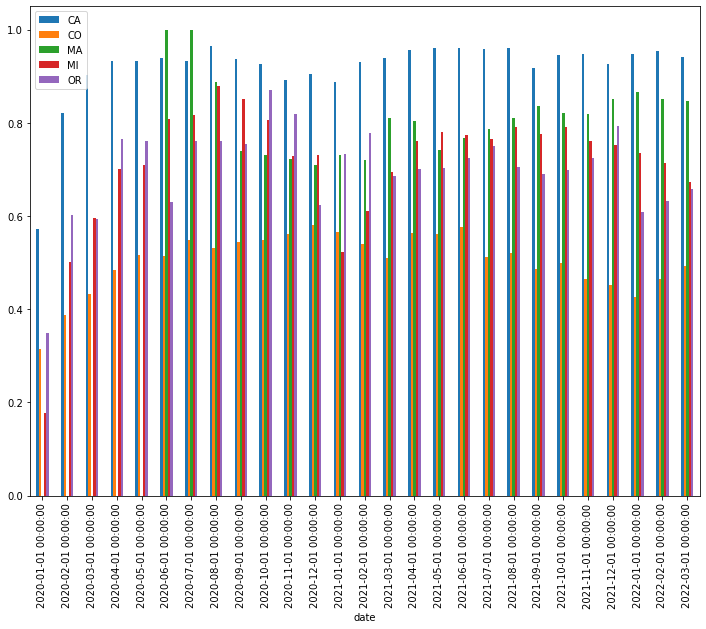

In [175]:
state_avg = df_with_state[['state','coverage','date']].groupby(['state','date']).mean().unstack().T.reset_index()
state_avg.index = pd.to_datetime(state_avg['date'])

ax = state_avg.plot(kind='bar', stacked=False,figsize = (12,9))
ax.legend(loc = 2)

In [176]:
state_avg

state,level_0,date,CA,CO,MA,MI,OR
date,,,,,,,
2020-01-01,coverage,2020-01,0.571754,0.315569,NaN,0.177982,0.349652
2020-02-01,coverage,2020-02,0.821382,0.387057,NaN,0.501894,0.602024
2020-03-01,coverage,2020-03,0.902558,0.432815,NaN,0.595821,0.594063
2020-04-01,coverage,2020-04,0.933230,0.483687,NaN,0.700714,0.765932
2020-05-01,coverage,2020-05,0.932018,0.517088,NaN,0.708861,0.760485
2020-06-01,coverage,2020-06,0.939965,0.514645,1.000000,0.809364,0.630613
2020-07-01,coverage,2020-07,0.933149,0.548368,1.000000,0.816450,0.761926
2020-08-01,coverage,2020-08,0.964293,0.531651,0.886953,0.880237,0.761335
2020-09-01,coverage,2020-09,0.937360,0.544990,0.740023,0.851683,0.754040


# inventory & coverage

In [60]:
today = date.today()
today

datetime.date(2022, 3, 16)

In [76]:
def read_inv_data(COMPANY_IDENTIFIER,license_numbers):
    
    company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
    )
    company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)
    return company_inventory_packages_dataframe


In [77]:
def calculate_inventory_valuation(incoming_transfer_df,inventory_df,license_list):
    # legal name
    legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
    # process df_in and df_sales
    #sales_df['per_unit'] = sales_df['tx_total_price'] / sales_df['tx_quantity_sold']
    #sales_df['year_month'] = sales_df['sales_datetime'].dt.strftime("%Y-%m")
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    incoming_transfer_df_price = incoming_transfer_df[incoming_transfer_df['shipper_wholesale_price'].notnull()]
    # by package id
    average_incoming_package_id = incoming_transfer_df_price.groupby(['package_id'])['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # by product
    average_incoming_product = incoming_transfer_df_price.groupby(['product_name'])['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    #calculate inventory
    df_inventory_incoming = pd.merge(inventory_df, df_avg_incoming_price, left_on=['package_id'],right_on = ['package_id'], how='left')
    df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
    df_inv_product = pd.merge(df_inv_null, df_avg_product, left_on=['product_name'],right_on = ['product_name'], how='left')
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
    df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    
    inventory_product_value = df_inv_product_price['total_price'].sum()
    df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
    inventory_value = df_inventory_incoming['total_price'].sum()
    total_inv_value = inventory_product_value + inventory_value
    inv_count_product = df_inv_product_price['per_unit_product'].count()
    inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
    inv_count_total = df_inventory_incoming['quantity'].count()
    inv_total_incoming = inv_count_product + inv_count_incoming
    inventory_coverage = inv_total_incoming / inv_count_total
    # prepare data
    data = [[today], 
            [total_inv_value], 
            [inv_total_incoming], 
            [inv_count_total], 
            [inventory_coverage],
            [license_list],
            [legal_name]]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = ['date','value','total_incoming','total','coverage','license','legal_name']
    return df_inventory_license
    

In [106]:
def get_inv_list(company_list,transfer_packages_start_date,sales_transactrions_start_date,map_df):
    inv_df_list = {}
    for c in tqdm(company_list):
        inv_list = {}
        print(c)
        l_list = map_df[map_df['company_identifier'] == c]['lic_list'].to_list()[0]
        for l in tqdm(l_list):
            print(l)
            df_in = read_df_in([c],[l])
            #df_sales = read_df_sales([c],[l])
            df_inv = read_inv_data([c],[l])
            if df_inv.shape[0] == 0:
                inv_list[l] = numpy.nan
                continue
            else:
                inv = calculate_inventory_valuation(df_in,df_inv,[l])
                inv_list[l] = inv
        inv_df_list[c] =  inv_list
    return inv_df_list

    

    

In [107]:
b = get_inv_list(list(ca_df_clean['company_identifier']),TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,ca_df_clean)




  0%|          | 0/62 [00:00<?, ?it/s]

99HT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000279-LIC



  2%|▏         | 1/62 [00:02<02:56,  2.89s/it]

ALT



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000310



 50%|█████     | 1/2 [00:01<00:01,  1.98s/it]

AU-R-000380



  3%|▎         | 2/62 [00:07<03:38,  3.65s/it]

BS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000185



 50%|█████     | 1/2 [00:01<00:01,  1.88s/it]

AU-R-000156



  5%|▍         | 3/62 [00:10<03:36,  3.67s/it]

BMC



  0%|          | 0/1 [00:00<?, ?it/s]

402-00930



  6%|▋         | 4/62 [00:12<02:58,  3.07s/it]

BBF



  0%|          | 0/1 [00:00<?, ?it/s]

MR281525



  8%|▊         | 5/62 [00:14<02:29,  2.62s/it]

BUD



  0%|          | 0/5 [00:00<?, ?it/s]

C9-0000464-LIC



 20%|██        | 1/5 [00:02<00:08,  2.12s/it]

C9-0000467-LIC



 40%|████      | 2/5 [00:04<00:06,  2.09s/it]

C9-0000444-LIC



 60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

C9-0000167-LIC



 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

C9-0000399-LIC



 10%|▉         | 6/62 [00:25<04:58,  5.33s/it]

CHO



  0%|          | 0/1 [00:00<?, ?it/s]

AU-R-000575



 11%|█▏        | 7/62 [00:27<03:48,  4.15s/it]

CG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000157-LIC



 13%|█▎        | 8/62 [00:29<03:16,  3.64s/it]

CPA



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000461-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.75s/it]

C9-0000348-LIC



 15%|█▍        | 9/62 [00:34<03:40,  4.16s/it]

CPC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000056-LIC



 16%|█▌        | 10/62 [00:36<03:01,  3.49s/it]

CSC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000670-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.91s/it]

C10-0000918-LIC



 18%|█▊        | 11/62 [00:41<03:18,  3.89s/it]

CCC



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000087-LIC



 19%|█▉        | 12/62 [00:45<03:10,  3.81s/it]

CC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000758-LIC



 21%|██        | 13/62 [00:47<02:40,  3.28s/it]

DWF



  0%|          | 0/1 [00:00<?, ?it/s]

402R-00804



 23%|██▎       | 14/62 [00:49<02:15,  2.81s/it]

DCO



  0%|          | 0/2 [00:00<?, ?it/s]

050-10052885D4C



 50%|█████     | 1/2 [00:02<00:02,  2.46s/it]

050-10070593E9E



 24%|██▍       | 15/62 [00:53<02:36,  3.33s/it]

DL



  0%|          | 0/1 [00:00<?, ?it/s]

MR283369



 26%|██▌       | 16/62 [00:55<02:11,  2.85s/it]

DGG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000016-LIC



 27%|██▋       | 17/62 [00:57<01:59,  2.66s/it]

DG



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000485



 17%|█▋        | 1/6 [00:01<00:08,  1.63s/it]

AU-R-000287



 33%|███▎      | 2/6 [00:03<00:06,  1.70s/it]

AU-R-000359



 50%|█████     | 3/6 [00:05<00:05,  1.80s/it]

AU-R-000422



 67%|██████▋   | 4/6 [00:07<00:03,  1.84s/it]

AU-R-000470



 83%|████████▎ | 5/6 [00:09<00:01,  1.86s/it]

AU-R-000572



 29%|██▉       | 18/62 [01:08<03:45,  5.13s/it]

EL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000370-LIC



 31%|███       | 19/62 [01:10<02:56,  4.11s/it]

EMA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000774-LIC



 32%|███▏      | 20/62 [01:12<02:28,  3.55s/it]

EMF



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000939-LIC



 34%|███▍      | 21/62 [01:14<02:05,  3.06s/it]

EMM



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000786-LIC



 35%|███▌      | 22/62 [01:16<01:51,  2.78s/it]

EMT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000695-LIC



 37%|███▋      | 23/62 [01:18<01:43,  2.66s/it]

EH



  0%|          | 0/1 [00:00<?, ?it/s]

MR283073



 39%|███▊      | 24/62 [01:20<01:30,  2.37s/it]

FW



  0%|          | 0/5 [00:00<?, ?it/s]

402-00558



 20%|██        | 1/5 [00:02<00:08,  2.21s/it]

402R-00017



 40%|████      | 2/5 [00:04<00:07,  2.49s/it]

402-00891



 60%|██████    | 3/5 [00:07<00:04,  2.34s/it]

402R-00020



 80%|████████  | 4/5 [00:09<00:02,  2.56s/it]

402R-00747



 40%|████      | 25/62 [01:32<03:16,  5.32s/it]

GT



  0%|          | 0/2 [00:00<?, ?it/s]

C9-0000385-LIC



 50%|█████     | 1/2 [00:01<00:01,  1.88s/it]

C9-0000170-LIC



 42%|████▏     | 26/62 [01:36<02:57,  4.93s/it]

GLNR



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000334



 17%|█▋        | 1/6 [00:01<00:07,  1.56s/it]

PC-000613



 33%|███▎      | 2/6 [00:03<00:06,  1.63s/it]

PC-000722



 50%|█████     | 3/6 [00:04<00:04,  1.62s/it]

AU-R-000182



 67%|██████▋   | 4/6 [00:06<00:03,  1.70s/it]

AU-R-000461



 83%|████████▎ | 5/6 [00:08<00:01,  1.67s/it]

AU-R-000559



 44%|████▎     | 27/62 [01:46<03:44,  6.42s/it]

GRG



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000169-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.76s/it]

C10-0000408-LIC



 45%|████▌     | 28/62 [01:51<03:23,  6.00s/it]

GTR



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000225



 50%|█████     | 1/2 [00:01<00:01,  1.89s/it]

AU-R-000163



 47%|████▋     | 29/62 [01:55<02:59,  5.43s/it]

GHC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000414-LIC



 48%|████▊     | 30/62 [01:57<02:22,  4.45s/it]

HB



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000339-LIC



 33%|███▎      | 1/3 [00:02<00:04,  2.18s/it]

C10-0000624-LIC



 67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]

C10-0000301-LIC



 50%|█████     | 31/62 [02:04<02:33,  4.94s/it]

HPCC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000064-LIC



 50%|█████     | 1/2 [00:03<00:03,  3.52s/it]

C10-0000005-LIC



 52%|█████▏    | 32/62 [02:09<02:33,  5.12s/it]

HC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000341-LIC



 53%|█████▎    | 33/62 [02:11<02:01,  4.19s/it]

IDC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000320-LIC



 55%|█████▍    | 34/62 [02:13<01:39,  3.55s/it]

KC



  0%|          | 0/11 [00:00<?, ?it/s]

402-00664



  9%|▉         | 1/11 [00:01<00:17,  1.73s/it]

402R-00515



 18%|█▊        | 2/11 [00:03<00:16,  1.87s/it]

402-01146



 27%|██▋       | 3/11 [00:05<00:15,  1.88s/it]

402-00573



 36%|███▋      | 4/11 [00:07<00:13,  1.90s/it]

402R-00544



 45%|████▌     | 5/11 [00:09<00:12,  2.02s/it]

402-00323



 55%|█████▍    | 6/11 [00:11<00:09,  1.96s/it]

402R-00900



 64%|██████▎   | 7/11 [00:13<00:08,  2.09s/it]

402R-00002



 73%|███████▎  | 8/11 [00:15<00:05,  1.95s/it]

402R-00035



 82%|████████▏ | 9/11 [00:17<00:03,  1.94s/it]

402R-00574



 91%|█████████ | 10/11 [00:19<00:01,  1.92s/it]

402-00037



 56%|█████▋    | 35/62 [02:35<04:00,  8.89s/it]

LBC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000154-LIC



 58%|█████▊    | 36/62 [02:36<02:55,  6.75s/it]

ML



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000300-LIC



 60%|█████▉    | 37/62 [02:39<02:17,  5.48s/it]

MW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000332-LIC



 61%|██████▏   | 38/62 [02:41<01:50,  4.62s/it]

MPW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000547-LIC



 63%|██████▎   | 39/62 [02:45<01:37,  4.22s/it]

MD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000247-LIC



 65%|██████▍   | 40/62 [02:47<01:18,  3.55s/it]

ND



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000427-LIC



 66%|██████▌   | 41/62 [02:48<01:03,  3.01s/it]

PGM



  0%|          | 0/11 [00:00<?, ?it/s]

PC-000160



  9%|▉         | 1/11 [00:01<00:18,  1.86s/it]

PC-000167



 18%|█▊        | 2/11 [00:03<00:17,  2.00s/it]

PC-000169



 27%|██▋       | 3/11 [00:05<00:15,  1.89s/it]

PC-000415



 36%|███▋      | 4/11 [00:07<00:12,  1.82s/it]

PC-000551



 45%|████▌     | 5/11 [00:09<00:10,  1.80s/it]

PC-000725



 55%|█████▍    | 6/11 [00:10<00:08,  1.70s/it]

AU-R-000196



 64%|██████▎   | 7/11 [00:12<00:07,  1.85s/it]

AU-R-000197



 73%|███████▎  | 8/11 [00:15<00:06,  2.01s/it]

AU-R-000198



 82%|████████▏ | 9/11 [00:17<00:04,  2.09s/it]

AU-R-000366



 91%|█████████ | 10/11 [00:19<00:02,  2.12s/it]

AU-R-000506



 68%|██████▊   | 42/62 [03:10<02:54,  8.73s/it]

PRP



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000403-LIC



 33%|███▎      | 1/3 [00:02<00:05,  2.59s/it]

C10-0000155-LIC



 67%|██████▋   | 2/3 [00:04<00:02,  2.32s/it]

C10-0000286-LIC



 69%|██████▉   | 43/62 [03:18<02:37,  8.27s/it]

PRL



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000759-LIC



 71%|███████   | 44/62 [03:20<01:55,  6.43s/it]

QR



  0%|          | 0/4 [00:00<?, ?it/s]

PC-000356



 25%|██▌       | 1/4 [00:01<00:04,  1.56s/it]

AU-R-000233



 50%|█████     | 2/4 [00:03<00:03,  1.88s/it]

AU-R-000346



 75%|███████▌  | 3/4 [00:05<00:01,  1.97s/it]

AU-R-000633



 73%|███████▎  | 45/62 [03:27<01:54,  6.75s/it]

RA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000596-LIC



 74%|███████▍  | 46/62 [03:30<01:26,  5.40s/it]

RGD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000057-LIC



 76%|███████▌  | 47/62 [03:32<01:06,  4.45s/it]

SFV



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000041-LIC



 77%|███████▋  | 48/62 [03:34<00:54,  3.92s/it]

SV



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000146-LIC



 79%|███████▉  | 49/62 [03:37<00:45,  3.46s/it]

SLCC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000474-LIC



 81%|████████  | 50/62 [03:39<00:35,  2.97s/it]

SO



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000271-LIC



 33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]

C12-0000328-LIC



 67%|██████▋   | 2/3 [00:03<00:01,  1.88s/it]

C9-0000130-LIC



 82%|████████▏ | 51/62 [03:44<00:41,  3.80s/it]

ST



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000323-LIC



 84%|████████▍ | 52/62 [03:46<00:32,  3.22s/it]

DW



  0%|          | 0/1 [00:00<?, ?it/s]

MR282376



 85%|████████▌ | 53/62 [03:48<00:25,  2.81s/it]

TGL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000412-LIC



 87%|████████▋ | 54/62 [03:50<00:20,  2.51s/it]

TJR



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000105-LIC



 89%|████████▊ | 55/62 [04:03<00:39,  5.68s/it]

TTS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000718



 50%|█████     | 1/2 [00:01<00:01,  1.83s/it]

AU-R-000546



 90%|█████████ | 56/62 [04:07<00:30,  5.06s/it]

TT



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000451-LIC



 92%|█████████▏| 57/62 [04:08<00:20,  4.08s/it]

T4L



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000302-LIC



 94%|█████████▎| 58/62 [04:11<00:13,  3.48s/it]

TL



  0%|          | 0/19 [00:00<?, ?it/s]

402R-00808



  5%|▌         | 1/19 [00:01<00:29,  1.66s/it]

402-00370



 11%|█         | 2/19 [00:06<01:02,  3.69s/it]

402R-00602



 16%|█▌        | 3/19 [00:17<01:51,  6.97s/it]

402R-00041



 21%|██        | 4/19 [00:23<01:36,  6.43s/it]

402R-00807



 26%|██▋       | 5/19 [00:28<01:25,  6.09s/it]

402-01142



 32%|███▏      | 6/19 [00:34<01:16,  5.86s/it]

402R-00573



 37%|███▋      | 7/19 [00:39<01:07,  5.61s/it]

402-00473



 42%|████▏     | 8/19 [00:43<00:57,  5.19s/it]

402R-00536



 47%|████▋     | 9/19 [00:47<00:49,  4.96s/it]

402R-00066



 53%|█████▎    | 10/19 [00:52<00:42,  4.77s/it]

402R-00362



 58%|█████▊    | 11/19 [00:55<00:35,  4.39s/it]

402-00390



 63%|██████▎   | 12/19 [01:01<00:32,  4.71s/it]

402-01201



 68%|██████▊   | 13/19 [01:05<00:28,  4.70s/it]

402R-00781



 74%|███████▎  | 14/19 [01:10<00:23,  4.69s/it]

402R-00505



 79%|███████▉  | 15/19 [01:13<00:16,  4.16s/it]

402R-00487



 84%|████████▍ | 16/19 [01:16<00:11,  3.88s/it]

402R-00242



 89%|████████▉ | 17/19 [01:19<00:07,  3.63s/it]

402R-00246



 95%|█████████▍| 18/19 [01:23<00:03,  3.62s/it]

402R-00571



 95%|█████████▌| 59/62 [05:37<01:25, 28.49s/it]

UHHC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000817-LIC



 50%|█████     | 1/2 [00:04<00:04,  4.50s/it]

C9-0000082-LIC



 97%|█████████▋| 60/62 [05:47<00:45, 22.87s/it]

VS



  0%|          | 0/2 [00:00<?, ?it/s]

402-00840



 50%|█████     | 1/2 [00:04<00:04,  4.35s/it]

402R-00545



 98%|█████████▊| 61/62 [05:56<00:18, 18.77s/it]

VOY



  0%|          | 0/3 [00:00<?, ?it/s]

C12-0000030-LIC



 33%|███▎      | 1/3 [00:05<00:10,  5.26s/it]

C10-0000802-LIC



 67%|██████▋   | 2/3 [00:10<00:04,  4.97s/it]

C12-0000159-LIC



100%|██████████| 62/62 [06:12<00:00,  6.00s/it]


In [114]:
b.keys()

dict_keys(['99HT', 'ALT', 'BS', 'BMC', 'BBF', 'BUD', 'CHO', 'CG', 'CPA', 'CPC', 'CSC', 'CCC', 'CC', 'DWF', 'DCO', 'DL', 'DGG', 'DG', 'EL', 'EMA', 'EMF', 'EMM', 'EMT', 'EH', 'FW', 'GT', 'GLNR', 'GRG', 'GTR', 'GHC', 'HB', 'HPCC', 'HC', 'IDC', 'KC', 'LBC', 'ML', 'MW', 'MPW', 'MD', 'ND', 'PGM', 'PRP', 'PRL', 'QR', 'RA', 'RGD', 'SFV', 'SV', 'SLCC', 'SO', 'ST', 'DW', 'TGL', 'TJR', 'TTS', 'TT', 'T4L', 'TL', 'UHHC', 'VS', 'VOY'])

In [115]:
for k in b.keys():
    print(k)
    for l in b[k].keys():
        print(l)

99HT
C10-0000279-LIC
ALT
PC-000310
AU-R-000380
BS
PC-000185
AU-R-000156
BMC
402-00930
BBF
MR281525
BUD
C9-0000464-LIC
C9-0000467-LIC
C9-0000444-LIC
C9-0000167-LIC
C9-0000399-LIC
CHO
AU-R-000575
CG
C9-0000157-LIC
CPA
C10-0000461-LIC
C9-0000348-LIC
CPC
C9-0000056-LIC
CSC
C10-0000670-LIC
C10-0000918-LIC
CCC
C12-0000087-LIC
CC
C10-0000758-LIC
DWF
402R-00804
DCO
050-10052885D4C
050-10070593E9E
DL
MR283369
DGG
C9-0000016-LIC
DG
PC-000485
AU-R-000287
AU-R-000359
AU-R-000422
AU-R-000470
AU-R-000572
EL
C9-0000370-LIC
EMA
C10-0000774-LIC
EMF
C10-0000939-LIC
EMM
C10-0000786-LIC
EMT
C10-0000695-LIC
EH
MR283073
FW
402-00558
402R-00017
402-00891
402R-00020
402R-00747
GT
C9-0000385-LIC
C9-0000170-LIC
GLNR
PC-000334
PC-000613
PC-000722
AU-R-000182
AU-R-000461
AU-R-000559
GRG
C10-0000169-LIC
C10-0000408-LIC
GTR
PC-000225
AU-R-000163
GHC
C10-0000414-LIC
HB
C10-0000339-LIC
C10-0000624-LIC
C10-0000301-LIC
HPCC
C10-0000064-LIC
C10-0000005-LIC
HC
C9-0000341-LIC
IDC
C9-0000320-LIC
KC
402-00664
402R-00515
402

In [130]:
str(b['QR']['AU-R-000233'])

'         date          value total_incoming total  coverage        license  \\\n0  2022-03-16  220886.548382            714   805  0.886957  [AU-R-000233]   \n\n            legal_name  \n0  Quality Roots, Inc.  '

In [131]:
df_inv = pd.DataFrame()
for k in b.keys():
    print(k)
    for l in b[k].keys():
        print(l)
        data_inv = b[k][l]
        if str(data_inv) == 'nan':
            continue
        else:
            data_inv['company'] = k
            data_inv['location'] = l
            print(data_inv.shape)
            df_inv = df_inv.append(data_inv)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(1, 9)
ALT
PC-000310
(1, 9)
AU-R-000380
(1, 9)
BS
PC-000185
(1, 9)
AU-R-000156
(1, 9)
BMC
402-00930
(1, 9)
BBF
MR281525
(1, 9)
BUD
C9-0000464-LIC
(1, 9)
C9-0000467-LIC
(1, 9)
C9-0000444-LIC
(1, 9)
C9-0000167-LIC
(1, 9)
C9-0000399-LIC
(1, 9)
CHO
AU-R-000575
(1, 9)
CG
C9-0000157-LIC
(1, 9)
CPA
C10-0000461-LIC
(1, 9)
C9-0000348-LIC
(1, 9)
CPC
C9-0000056-LIC
(1, 9)
CSC
C10-0000670-LIC
(1, 9)
C10-0000918-LIC
(1, 9)
CCC
C12-0000087-LIC
(1, 9)
CC
C10-0000758-LIC
(1, 9)
DWF
402R-00804
(1, 9)
DCO
050-10052885D4C
(1, 9)
050-10070593E9E
(1, 9)
DL
MR283369
(1, 9)
DGG
C9-0000016-LIC
(1, 9)
DG
PC-000485
(1, 9)
AU-R-000287
(1, 9)
AU-R-000359
(1, 9)
AU-R-000422
(1, 9)
AU-R-000470
(1, 9)
AU-R-000572
(1, 9)
EL
C9-0000370-LIC
(1, 9)
EMA
C10-0000774-LIC
(1, 9)
EMF
C10-0000939-LIC
(1, 9)
EMM
C10-0000786-LIC
(1, 9)
EMT
C10-0000695-LIC
(1, 9)
EH
MR283073
(1, 9)
FW
402-00558
(1, 9)
402R-00017
(1, 9)
402-00891
(1, 9)
402R-00020
(1, 9)
402R-00747
(1, 9)
GT
C9-0000385-LIC
(1, 9)
C9-0000170-L

In [135]:
#df_inv.to_csv('all_metrc_inv_0316.csv')



In [138]:
len(df_inv['company'].unique())

62

In [141]:
df_inv['id'] = list(zip(df_inv.company, df_inv.location))
df_inv = df_inv.reset_index(drop = True)

In [142]:
len(df_inv['id'].unique())

133

In [178]:
df_inv_with_state = pd.merge(df_inv,ca_df_clean[['company_identifier','state']],left_on = 'company',right_on = 'company_identifier',how = 'left')



In [201]:
#df_inv_with_state.to_csv('all_metrc_inv_0317.csv')

In [192]:
df_inv_with_state['coverage'] = df_inv_with_state['coverage'].astype('float')

In [197]:
state_count_inv = df_inv_with_state[['state','id']].groupby(['state']).count().unstack().T.reset_index()
state_avg_inv = df_inv_with_state[['state','coverage']].groupby(['state']).mean().unstack().T.reset_index()
state_med_inv = df_inv_with_state[['state','coverage']].groupby(['state']).median().unstack().T.reset_index()



In [198]:
state_count_inv

,level_0,state,0
0,id,CA,60
1,id,CO,32
2,id,MA,4
3,id,MI,35
4,id,OR,2


In [199]:
state_avg_inv

,level_0,state,0
0,coverage,CA,0.885191
1,coverage,CO,0.534361
2,coverage,MA,0.937195
3,coverage,MI,0.726194
4,coverage,OR,0.751646


In [200]:
state_med_inv

,level_0,state,0
0,coverage,CA,0.952039
1,coverage,CO,0.532624
2,coverage,MA,0.964554
3,coverage,MI,0.752277
4,coverage,OR,0.751646


In [229]:
co_inv = df_inv_with_state[df_inv_with_state['state'] == 'MI'][['id','coverage']]
co_inv.index = co_inv.id

In [230]:
co_inv

,id,coverage
id,,
"(ALT, PC-000310)","(ALT, PC-000310)",0.992701
"(ALT, AU-R-000380)","(ALT, AU-R-000380)",0.979960
"(BS, PC-000185)","(BS, PC-000185)",0.545852
"(BS, AU-R-000156)","(BS, AU-R-000156)",0.513126
"(CHO, AU-R-000575)","(CHO, AU-R-000575)",0.650930
"(DG, PC-000485)","(DG, PC-000485)",1.000000
"(DG, AU-R-000287)","(DG, AU-R-000287)",0.391414
"(DG, AU-R-000359)","(DG, AU-R-000359)",0.953451
"(DG, AU-R-000422)","(DG, AU-R-000422)",0.455326


<AxesSubplot:xlabel='id'>

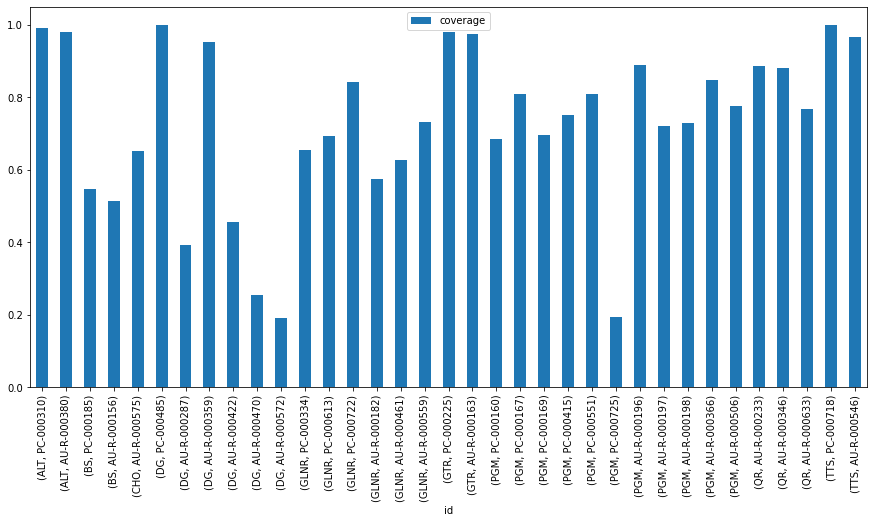

In [231]:
co_inv.plot(kind = 'bar',figsize = (15,7))

# Vendor Churn

In [232]:
WINDOW = 4
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-03-01'
VC_MONTH_LIST = ['2021-11-01','2021-12-01','2022-01-01','2022-02-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [237]:
def calculate_vendor_churn(incoming_transfer_df,license_list,vc_windown,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop('__place_holder', axis=1)
        )
    ).reset_index(drop=True)
    
    rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(vc_windown).sum()
    )
    rolling_4m_sum.columns = ['rolling_4m_total_price']
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_4m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
    vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn
    


In [238]:
def get_vc_list(company_list,transfer_packages_start_date,sales_transactrions_start_date,map_df):
    vc_df_list = {}
    for c in tqdm(company_list):
        vc_list = {}
        print(c)
        l_list = map_df[map_df['company_identifier'] == c]['lic_list'].to_list()[0]
        for l in tqdm(l_list):
            print(l)
            df_in = read_df_in([c],[l])
            #df_sales = read_df_sales([c],[l])
            #df_inv = read_inv_data([c],[l])
            if df_in.shape[0] == 0:
                vc_list[l] = numpy.nan
                continue
            else:
                vc = calculate_vendor_churn(df_in,[l],WINDOW,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
                vc_list[l] = vc
        vc_df_list[c] =  vc_list
    return vc_df_list

    

    

In [244]:
c = get_vc_list(list(ca_df_clean['company_identifier']),TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,ca_df_clean)




  0%|          | 0/62 [00:00<?, ?it/s]

99HT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000279-LIC



  2%|▏         | 1/62 [00:01<01:39,  1.63s/it]

ALT



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000310



 50%|█████     | 1/2 [00:01<00:01,  1.31s/it]

AU-R-000380



  3%|▎         | 2/62 [00:04<02:16,  2.28s/it]

BS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000185



 50%|█████     | 1/2 [00:01<00:01,  1.51s/it]

AU-R-000156



  5%|▍         | 3/62 [00:07<02:32,  2.58s/it]

BMC



  0%|          | 0/1 [00:00<?, ?it/s]

402-00930



  6%|▋         | 4/62 [00:10<02:35,  2.69s/it]

BBF



  0%|          | 0/1 [00:00<?, ?it/s]

MR281525



  8%|▊         | 5/62 [00:12<02:32,  2.68s/it]

BUD



  0%|          | 0/5 [00:00<?, ?it/s]

C9-0000464-LIC



 20%|██        | 1/5 [00:02<00:11,  2.94s/it]

C9-0000467-LIC



 40%|████      | 2/5 [00:05<00:08,  2.89s/it]

C9-0000444-LIC



 60%|██████    | 3/5 [00:08<00:05,  2.78s/it]

C9-0000167-LIC



 80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

C9-0000399-LIC



 10%|▉         | 6/62 [00:27<06:20,  6.80s/it]

CHO



  0%|          | 0/1 [00:00<?, ?it/s]

AU-R-000575



 11%|█▏        | 7/62 [00:30<04:58,  5.42s/it]

CG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000157-LIC



 13%|█▎        | 8/62 [00:33<04:23,  4.88s/it]

CPA



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000461-LIC



 50%|█████     | 1/2 [00:04<00:04,  4.44s/it]

C9-0000348-LIC



 15%|█▍        | 9/62 [00:41<05:10,  5.86s/it]

CPC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000056-LIC



 16%|█▌        | 10/62 [00:45<04:22,  5.04s/it]

CSC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000670-LIC



 50%|█████     | 1/2 [00:03<00:03,  3.74s/it]

C10-0000918-LIC



 18%|█▊        | 11/62 [00:51<04:43,  5.56s/it]

CCC



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000087-LIC



 19%|█▉        | 12/62 [00:56<04:20,  5.20s/it]

CC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000758-LIC



 21%|██        | 13/62 [00:59<03:45,  4.61s/it]

DWF



  0%|          | 0/1 [00:00<?, ?it/s]

402R-00804



 23%|██▎       | 14/62 [01:02<03:13,  4.02s/it]

DCO



  0%|          | 0/2 [00:00<?, ?it/s]

050-10052885D4C



 50%|█████     | 1/2 [00:03<00:03,  3.35s/it]

050-10070593E9E



 24%|██▍       | 15/62 [01:08<03:44,  4.79s/it]

DL



  0%|          | 0/1 [00:00<?, ?it/s]

MR283369



 26%|██▌       | 16/62 [01:11<03:09,  4.11s/it]

DGG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000016-LIC



 27%|██▋       | 17/62 [01:14<02:49,  3.76s/it]

DG



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000485



 17%|█▋        | 1/6 [00:02<00:10,  2.18s/it]

AU-R-000287



 33%|███▎      | 2/6 [00:05<00:10,  2.65s/it]

AU-R-000359



 50%|█████     | 3/6 [00:08<00:08,  3.00s/it]

AU-R-000422



 67%|██████▋   | 4/6 [00:11<00:05,  2.99s/it]

AU-R-000470



 83%|████████▎ | 5/6 [00:14<00:02,  2.92s/it]

AU-R-000572



 29%|██▉       | 18/62 [01:30<05:36,  7.65s/it]

EL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000370-LIC



 31%|███       | 19/62 [01:34<04:29,  6.27s/it]

EMA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000774-LIC



 32%|███▏      | 20/62 [01:37<03:50,  5.48s/it]

EMF



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000939-LIC



 34%|███▍      | 21/62 [01:41<03:19,  4.86s/it]

EMM



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000786-LIC



 35%|███▌      | 22/62 [01:44<02:55,  4.39s/it]

EMT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000695-LIC



 37%|███▋      | 23/62 [01:48<02:42,  4.17s/it]

EH



  0%|          | 0/1 [00:00<?, ?it/s]

MR283073



 39%|███▊      | 24/62 [01:50<02:16,  3.60s/it]

FW



  0%|          | 0/5 [00:00<?, ?it/s]

402-00558



 20%|██        | 1/5 [00:02<00:11,  2.81s/it]

402R-00017



 40%|████      | 2/5 [00:07<00:11,  3.82s/it]

402-00891



 60%|██████    | 3/5 [00:10<00:07,  3.62s/it]

402R-00020



 80%|████████  | 4/5 [00:15<00:03,  3.91s/it]

402R-00747



 40%|████      | 25/62 [02:09<05:02,  8.18s/it]

GT



  0%|          | 0/2 [00:00<?, ?it/s]

C9-0000385-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.86s/it]

C9-0000170-LIC



 42%|████▏     | 26/62 [02:14<04:28,  7.45s/it]

GLNR



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000334



 17%|█▋        | 1/6 [00:02<00:12,  2.47s/it]

PC-000613



 33%|███▎      | 2/6 [00:04<00:08,  2.14s/it]

PC-000722



 50%|█████     | 3/6 [00:06<00:06,  2.18s/it]

AU-R-000182



 67%|██████▋   | 4/6 [00:09<00:04,  2.46s/it]

AU-R-000461



 83%|████████▎ | 5/6 [00:11<00:02,  2.33s/it]

AU-R-000559



 44%|████▎     | 27/62 [02:28<05:26,  9.34s/it]

GRG



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000169-LIC



 50%|█████     | 1/2 [00:04<00:04,  4.14s/it]

C10-0000408-LIC



 45%|████▌     | 28/62 [02:36<05:00,  8.83s/it]

GTR



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000225



 50%|█████     | 1/2 [00:03<00:03,  3.01s/it]

AU-R-000163



 47%|████▋     | 29/62 [02:42<04:27,  8.10s/it]

GHC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000414-LIC



 48%|████▊     | 30/62 [02:46<03:34,  6.70s/it]

HB



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000339-LIC



 33%|███▎      | 1/3 [00:03<00:07,  3.83s/it]

C10-0000624-LIC



 67%|██████▋   | 2/3 [00:06<00:03,  3.35s/it]

C10-0000301-LIC



 50%|█████     | 31/62 [02:55<03:56,  7.63s/it]

HPCC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000064-LIC



 50%|█████     | 1/2 [00:06<00:06,  6.07s/it]

C10-0000005-LIC



 52%|█████▏    | 32/62 [03:05<04:07,  8.24s/it]

HC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000341-LIC



 53%|█████▎    | 33/62 [03:08<03:10,  6.58s/it]

IDC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000320-LIC



 55%|█████▍    | 34/62 [03:11<02:38,  5.66s/it]

KC



  0%|          | 0/11 [00:00<?, ?it/s]

402-00664



  9%|▉         | 1/11 [00:02<00:26,  2.69s/it]

402R-00515



 18%|█▊        | 2/11 [00:06<00:28,  3.15s/it]

402-01146



 27%|██▋       | 3/11 [00:08<00:20,  2.62s/it]

402-00573



 36%|███▋      | 4/11 [00:11<00:19,  2.72s/it]

402R-00544



 45%|████▌     | 5/11 [00:14<00:18,  3.11s/it]

402-00323



 55%|█████▍    | 6/11 [00:17<00:14,  2.98s/it]

402R-00900



 64%|██████▎   | 7/11 [00:20<00:11,  2.96s/it]

402R-00002



 73%|███████▎  | 8/11 [00:23<00:08,  2.96s/it]

402R-00035



 82%|████████▏ | 9/11 [00:26<00:05,  3.00s/it]

402R-00574



 91%|█████████ | 10/11 [00:29<00:03,  3.01s/it]

402-00037



 56%|█████▋    | 35/62 [03:43<06:07, 13.62s/it]

LBC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000154-LIC



 58%|█████▊    | 36/62 [03:46<04:29, 10.36s/it]

ML



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000300-LIC



 60%|█████▉    | 37/62 [03:50<03:28,  8.34s/it]

MW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000332-LIC



 61%|██████▏   | 38/62 [03:54<02:51,  7.13s/it]

MPW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000547-LIC



 63%|██████▎   | 39/62 [03:58<02:23,  6.24s/it]

MD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000247-LIC



 65%|██████▍   | 40/62 [04:02<01:57,  5.34s/it]

ND



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000427-LIC



 66%|██████▌   | 41/62 [04:04<01:35,  4.53s/it]

PGM



  0%|          | 0/11 [00:00<?, ?it/s]

PC-000160



  9%|▉         | 1/11 [00:02<00:20,  2.02s/it]

PC-000167



 18%|█▊        | 2/11 [00:04<00:21,  2.44s/it]

PC-000169



 27%|██▋       | 3/11 [00:07<00:18,  2.36s/it]

PC-000415



 36%|███▋      | 4/11 [00:09<00:17,  2.45s/it]

PC-000551



 45%|████▌     | 5/11 [00:11<00:13,  2.27s/it]

PC-000725



 55%|█████▍    | 6/11 [00:13<00:10,  2.16s/it]

AU-R-000196



 64%|██████▎   | 7/11 [00:16<00:10,  2.53s/it]

AU-R-000197



 73%|███████▎  | 8/11 [00:19<00:07,  2.59s/it]

AU-R-000198



 82%|████████▏ | 9/11 [00:22<00:05,  2.63s/it]

AU-R-000366



 91%|█████████ | 10/11 [00:25<00:02,  2.73s/it]

AU-R-000506



 68%|██████▊   | 42/62 [04:33<03:53, 11.68s/it]

PRP



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000403-LIC



 33%|███▎      | 1/3 [00:03<00:07,  3.63s/it]

C10-0000155-LIC



 67%|██████▋   | 2/3 [00:07<00:03,  3.61s/it]

C10-0000286-LIC



 69%|██████▉   | 43/62 [04:43<03:35, 11.34s/it]

PRL



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000759-LIC



 71%|███████   | 44/62 [04:47<02:41,  8.95s/it]

QR



  0%|          | 0/4 [00:00<?, ?it/s]

PC-000356



 25%|██▌       | 1/4 [00:02<00:06,  2.02s/it]

AU-R-000233



 50%|█████     | 2/4 [00:05<00:05,  2.65s/it]

AU-R-000346



 75%|███████▌  | 3/4 [00:08<00:02,  2.81s/it]

AU-R-000633



 73%|███████▎  | 45/62 [04:57<02:41,  9.50s/it]

RA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000596-LIC



 74%|███████▍  | 46/62 [05:00<02:01,  7.59s/it]

RGD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000057-LIC



 76%|███████▌  | 47/62 [05:03<01:32,  6.18s/it]

SFV



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000041-LIC



 77%|███████▋  | 48/62 [05:07<01:15,  5.41s/it]

SV



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000146-LIC



 79%|███████▉  | 49/62 [05:10<01:00,  4.68s/it]

SLCC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000474-LIC



 81%|████████  | 50/62 [05:13<00:50,  4.24s/it]

SO



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000271-LIC



 33%|███▎      | 1/3 [00:03<00:06,  3.32s/it]

C12-0000328-LIC



 67%|██████▋   | 2/3 [00:05<00:02,  2.57s/it]

C9-0000130-LIC



 82%|████████▏ | 51/62 [05:22<01:00,  5.51s/it]

ST



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000323-LIC



 84%|████████▍ | 52/62 [05:24<00:47,  4.70s/it]

DW



  0%|          | 0/1 [00:00<?, ?it/s]

MR282376



 85%|████████▌ | 53/62 [05:28<00:38,  4.28s/it]

TGL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000412-LIC



 87%|████████▋ | 54/62 [05:31<00:31,  3.91s/it]

TJR



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000105-LIC



 89%|████████▊ | 55/62 [05:45<00:48,  6.88s/it]

TTS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000718



 50%|█████     | 1/2 [00:02<00:02,  2.10s/it]

AU-R-000546



 90%|█████████ | 56/62 [05:49<00:36,  6.11s/it]

TT



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000451-LIC



 92%|█████████▏| 57/62 [05:52<00:25,  5.12s/it]

T4L



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000302-LIC



 94%|█████████▎| 58/62 [05:55<00:18,  4.60s/it]

TL



  0%|          | 0/19 [00:00<?, ?it/s]

402R-00808



  5%|▌         | 1/19 [00:01<00:29,  1.65s/it]

402-00370



 11%|█         | 2/19 [00:04<00:37,  2.22s/it]

402R-00602



 16%|█▌        | 3/19 [00:07<00:41,  2.62s/it]

402R-00041



 21%|██        | 4/19 [00:11<00:45,  3.03s/it]

402R-00807



 26%|██▋       | 5/19 [00:14<00:42,  3.07s/it]

402-01142



 32%|███▏      | 6/19 [00:16<00:37,  2.91s/it]

402R-00573



 37%|███▋      | 7/19 [00:19<00:35,  2.96s/it]

402-00473



 42%|████▏     | 8/19 [00:22<00:31,  2.85s/it]

402R-00536



 47%|████▋     | 9/19 [00:25<00:29,  2.94s/it]

402R-00066



 53%|█████▎    | 10/19 [00:28<00:26,  2.97s/it]

402R-00362



 58%|█████▊    | 11/19 [00:30<00:20,  2.55s/it]

402-00390



 63%|██████▎   | 12/19 [00:33<00:19,  2.72s/it]

402-01201



 68%|██████▊   | 13/19 [00:36<00:17,  2.92s/it]

402R-00781



 74%|███████▎  | 14/19 [00:39<00:14,  2.94s/it]

402R-00505



 79%|███████▉  | 15/19 [00:41<00:10,  2.57s/it]

402R-00487



 84%|████████▍ | 16/19 [00:43<00:06,  2.29s/it]

402R-00242



 89%|████████▉ | 17/19 [00:44<00:04,  2.10s/it]

402R-00246



 95%|█████████▍| 18/19 [00:46<00:02,  2.11s/it]

402R-00571



 95%|█████████▌| 59/62 [06:43<00:53, 17.74s/it]

UHHC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000817-LIC



 50%|█████     | 1/2 [00:03<00:03,  3.12s/it]

C9-0000082-LIC



 97%|█████████▋| 60/62 [06:51<00:29, 14.62s/it]

VS



  0%|          | 0/2 [00:00<?, ?it/s]

402-00840



 50%|█████     | 1/2 [00:02<00:02,  2.68s/it]

402R-00545



 98%|█████████▊| 61/62 [06:58<00:12, 12.32s/it]

VOY



  0%|          | 0/3 [00:00<?, ?it/s]

C12-0000030-LIC



 33%|███▎      | 1/3 [00:04<00:08,  4.26s/it]

C10-0000802-LIC



 67%|██████▋   | 2/3 [00:06<00:03,  3.22s/it]

C12-0000159-LIC



100%|██████████| 62/62 [07:07<00:00,  6.89s/it]


In [245]:
df_vc = pd.DataFrame()
for k in c.keys():
    print(k)
    for l in c[k].keys():
        print(l)
        data_vc = c[k][l]
        if str(data_vc) == 'nan':
            continue
        else:
            data_vc['company'] = k
            data_vc['location'] = l
            print(data_vc.shape)
            df_vc = df_vc.append(data_vc)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(27, 4)
ALT
PC-000310
(27, 4)
AU-R-000380
(27, 4)
BS
PC-000185
(27, 4)
AU-R-000156
(27, 4)
BMC
402-00930
(27, 4)
BBF
MR281525
(27, 4)
BUD
C9-0000464-LIC
(27, 4)
C9-0000467-LIC
(27, 4)
C9-0000444-LIC
(27, 4)
C9-0000167-LIC
(27, 4)
C9-0000399-LIC
(27, 4)
CHO
AU-R-000575
(27, 4)
CG
C9-0000157-LIC
(27, 4)
CPA
C10-0000461-LIC
(27, 4)
C9-0000348-LIC
(27, 4)
CPC
C9-0000056-LIC
(27, 4)
CSC
C10-0000670-LIC
(27, 4)
C10-0000918-LIC
(27, 4)
CCC
C12-0000087-LIC
(27, 4)
CC
C10-0000758-LIC
(27, 4)
DWF
402R-00804
(27, 4)
DCO
050-10052885D4C
(27, 4)
050-10070593E9E
(27, 4)
DL
MR283369
(27, 4)
DGG
C9-0000016-LIC
(27, 4)
DG
PC-000485
(27, 4)
AU-R-000287
(27, 4)
AU-R-000359
(27, 4)
AU-R-000422
(27, 4)
AU-R-000470
(27, 4)
AU-R-000572
(27, 4)
EL
C9-0000370-LIC
(27, 4)
EMA
C10-0000774-LIC
(27, 4)
EMF
C10-0000939-LIC
(27, 4)
EMM
C10-0000786-LIC
(27, 4)
EMT
C10-0000695-LIC
(27, 4)
EH
MR283073
(27, 4)
FW
402-00558
(27, 4)
402R-00017
(27, 4)
402-00891
(27, 4)
402R-00020
(27, 4)
402R-00747
(2

In [251]:
df_vc['id'] = list(zip(df_vc.company, df_vc.location))
df_vc = df_vc.reset_index(drop = True)

In [252]:
len(df_vc['id'].unique())

135

In [255]:
df_vc_with_state = pd.merge(df_vc,ca_df_clean[['company_identifier','state']],left_on = 'company',right_on = 'company_identifier',how = 'left')

df_vc_with_state.to_csv('all_metrc_vc_0322.csv')




,year_month,%_inactive,company,location,id,company_identifier,state
0,2020-01-01,0.0,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)",99HT,CA
1,2020-02-01,1.0,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)",99HT,CA
2,2020-03-01,1.0,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)",99HT,CA
3,2020-04-01,0.0,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)",99HT,CA
4,2020-05-01,0.0,99HT,C10-0000279-LIC,"(99HT, C10-0000279-LIC)",99HT,CA
...,...,...,...,...,...,...,...
3640,2021-11-01,1.0,VOY,C12-0000159-LIC,"(VOY, C12-0000159-LIC)",VOY,CA
3641,2021-12-01,1.0,VOY,C12-0000159-LIC,"(VOY, C12-0000159-LIC)",VOY,CA
3642,2022-01-01,1.0,VOY,C12-0000159-LIC,"(VOY, C12-0000159-LIC)",VOY,CA
3643,2022-02-01,1.0,VOY,C12-0000159-LIC,"(VOY, C12-0000159-LIC)",VOY,CA


In [295]:
df_vc_with_state.to_csv('all_metrc_vc_0322.csv')

In [290]:
df_vc_with_state_feb = df_vc_with_state[df_vc_with_state['year_month'] == '2022-02-01']

In [306]:
state_count_vc = df_vc_with_state[['state','year_month','id']].groupby(['state','year_month']).count().unstack().T.reset_index()
state_avg_vc = df_vc_with_state[['state','year_month','%_inactive']].groupby(['state','year_month']).mean().unstack().T.reset_index()
state_med_vc = df_vc_with_state[['state','year_month','%_inactive']].groupby(['state','year_month']).median().unstack().T.reset_index()



In [307]:
state_count_vc


state,level_0,year_month,CA,CO,MA,MI,OR
0,id,2020-01-01,60,33,4,36,2
1,id,2020-02-01,60,33,4,36,2
2,id,2020-03-01,60,33,4,36,2
3,id,2020-04-01,60,33,4,36,2
4,id,2020-05-01,60,33,4,36,2
5,id,2020-06-01,60,33,4,36,2
6,id,2020-07-01,60,33,4,36,2
7,id,2020-08-01,60,33,4,36,2
8,id,2020-09-01,60,33,4,36,2
9,id,2020-10-01,60,33,4,36,2


# flowhub

In [256]:
fh = pd.read_csv('flowhub_aftertax_cogs_0322.csv',index_col= 0)

In [257]:
fh

,year_month,subtotalInDollars,costInDollars,subtotalInDollars_after_tax,profit,profit_after_tax,margin_perc,margin_perc_after_tax,location_id,location_state,margin_final
0,2021-01,589684.34,274251.68,678136.9910,315432.66,403885.3110,0.534918,0.595581,dpRSNtHhdo5W6Ywc7,OR,0.534918
1,2021-02,506394.25,227708.18,582353.3875,278686.07,354645.2075,0.550334,0.608986,dpRSNtHhdo5W6Ywc7,OR,0.550334
2,2021-03,557228.06,243101.56,640812.2690,314126.50,397710.7090,0.563731,0.620635,dpRSNtHhdo5W6Ywc7,OR,0.563731
3,2021-04,538883.33,233897.33,619715.8295,304986.00,385818.4995,0.565959,0.622573,dpRSNtHhdo5W6Ywc7,OR,0.565959
4,2021-05,530911.57,229260.76,610548.3055,301650.81,381287.5455,0.568175,0.624500,dpRSNtHhdo5W6Ywc7,OR,0.568175
...,...,...,...,...,...,...,...,...,...,...,...
3528,2021-10,263633.00,140963.02,303177.9500,122669.98,162214.9300,0.465306,0.535049,oT9Y9S9wG9xzkCqTH,CO,0.465306
3529,2021-11,205825.00,103465.05,236698.7500,102359.95,133233.7000,0.497315,0.562883,oT9Y9S9wG9xzkCqTH,CO,0.497315
3530,2021-12,176899.58,85235.91,203434.5170,91663.67,118198.6070,0.518168,0.581015,oT9Y9S9wG9xzkCqTH,CO,0.518168
3531,2022-01,157446.67,71992.69,181063.6705,85453.98,109070.9805,0.542749,0.602390,oT9Y9S9wG9xzkCqTH,CO,0.542749


In [275]:
fh_clean = fh[['year_month','subtotalInDollars','location_id','location_state','margin_perc']]

In [276]:
fh_clean

,year_month,subtotalInDollars,location_id,location_state,margin_perc
0,2021-01,589684.34,dpRSNtHhdo5W6Ywc7,OR,0.534918
1,2021-02,506394.25,dpRSNtHhdo5W6Ywc7,OR,0.550334
2,2021-03,557228.06,dpRSNtHhdo5W6Ywc7,OR,0.563731
3,2021-04,538883.33,dpRSNtHhdo5W6Ywc7,OR,0.565959
4,2021-05,530911.57,dpRSNtHhdo5W6Ywc7,OR,0.568175
...,...,...,...,...,...
3528,2021-10,263633.00,oT9Y9S9wG9xzkCqTH,CO,0.465306
3529,2021-11,205825.00,oT9Y9S9wG9xzkCqTH,CO,0.497315
3530,2021-12,176899.58,oT9Y9S9wG9xzkCqTH,CO,0.518168
3531,2022-01,157446.67,oT9Y9S9wG9xzkCqTH,CO,0.542749


In [348]:
df_with_state_clean = df_with_state[['date','revenue','id','state','margin_%']]

In [352]:
fh_clean.columns = df_with_state_clean.columns

In [353]:
joined = fh_clean.append(df_with_state_clean)

In [361]:
joined.head()

,date,revenue,id,state,margin_%
0,2021-01-01,589684.34,dpRSNtHhdo5W6Ywc7,OR,0.534918
1,2021-02-01,506394.25,dpRSNtHhdo5W6Ywc7,OR,0.550334
2,2021-03-01,557228.06,dpRSNtHhdo5W6Ywc7,OR,0.563731
3,2021-04-01,538883.33,dpRSNtHhdo5W6Ywc7,OR,0.565959
4,2021-05-01,530911.57,dpRSNtHhdo5W6Ywc7,OR,0.568175


In [355]:
joined['date'] = pd.to_datetime(joined['date'])

In [356]:
df_mom_rev = joined.groupby('id').apply(lambda df: df.set_index('date').resample('1MS').first()['revenue'].pct_change()).reset_index()

In [360]:
df_mom_rev.columns = ['id','date','rev_change']

In [364]:
metrc_fh = df_mom_rev.merge(joined,on = ['id','date'],how = 'right')

In [377]:
fh_all = metrc_fh.loc[:3375]

In [451]:
fh_all.groupby(['state'])['revenue'].describe().reset_index()

,state,count,mean,std,min,25%,50%,75%,max
0,CA,458.0,433845.646535,469423.969406,15.00,94192.265,225333.225,633672.6900,2713224.445
1,CO,1065.0,171061.796253,185236.396392,231.77,49884.980,122194.400,211034.1700,1247167.790
2,MA,120.0,466599.045333,428691.984331,25.00,94981.875,402429.215,644275.0600,1593317.320
3,MI,604.0,362051.969795,363673.775163,4.00,81297.590,228892.310,582423.7425,1873877.265
4,OR,1129.0,184527.709826,259232.798675,30.00,68464.790,131498.900,215260.6500,2730445.660


In [383]:
fh_all[['date','state','id']].groupby(['date','state']).count().unstack().reset_index()

date  id                
state             CA  CO  MA  MI  OR
0     2021-01-01  28  66   5  34  69
1     2021-02-01  30  67   5  35  75
2     2021-03-01  30  70   6  37  75
3     2021-04-01  30  71   7  36  77
4     2021-05-01  33  71   8  37  78
5     2021-06-01  32  77   8  42  80
6     2021-07-01  32  78   8  44  82
7     2021-08-01  34  81   8  44  82
8     2021-09-01  34  79  10  45  83
9     2021-10-01  35  80  10  48  83
10    2021-11-01  34  76  11  50  84
11    2021-12-01  39  83  11  50  87
12    2022-01-01  34  86  11  52  87
13    2022-02-01  33  80  12  50  87

In [388]:
metrc_all  = metrc_fh.loc[3376:]

In [390]:
metrc_all[['date','state','id']].groupby(['date','state']).count().unstack().reset_index()

date    id                      
state               CA    CO   MA    MI   OR
0     2020-01-01  16.0  27.0  NaN   3.0  2.0
1     2020-02-01  16.0  28.0  NaN   5.0  2.0
2     2020-03-01  19.0  27.0  NaN   5.0  2.0
3     2020-04-01  21.0  27.0  NaN   5.0  2.0
4     2020-05-01  23.0  27.0  NaN   6.0  2.0
5     2020-06-01  24.0  27.0  1.0   6.0  2.0
6     2020-07-01  27.0  27.0  2.0   6.0  2.0
7     2020-08-01  28.0  27.0  2.0   6.0  2.0
8     2020-09-01  28.0  28.0  2.0   6.0  2.0
9     2020-10-01  28.0  28.0  2.0   6.0  2.0
10    2020-11-01  31.0  28.0  2.0   6.0  2.0
11    2020-12-01  33.0  28.0  2.0   6.0  2.0
12    2021-01-01  40.0  28.0  2.0  18.0  2.0
13    2021-02-01  40.0  28.0  2.0  22.0  2.0
14    2021-03-01  43.0  30.0  2.0  23.0  2.0
15    2021-04-01  44.0  29.0  2.0  24.0  2.0
16    2021-05-01  44.0  29.0  2.0  23.0  2.0
17    2021-06-01  45.0  29.0  2.0  23.0  2.0
18    2021-07-01  46.0  31.0  3.0  26.0  2.0
19    2021-08-01  48.0  29.0  3.0  27.0  2.0
20    2021-09-01  52.0  31.0  4.0  27.0  2.0
21    2021-10-01  51.0  29.0  4.0  28.0  2.0
22    2021-11-01  51.0  31.0  4.0  32.0  2.0
23    2021-12-01  52.0  29.0  4.0  34.0  1.0
24    2022-01-01  50.0  30.0  4.0  34.0  2.0
25    2022-02-01  52.0  30.0  4.0  35.0  2.0
26    2022-03-01  47.0  21.0  3.0  35.0  2.0

In [391]:
metrc_all.head()

,id,date,rev_change,revenue,state,margin_%
3376,"(99HT, C10-0000279-LIC)",2021-01-01,NaN,291646.25,CA,0.760173
3377,"(99HT, C10-0000279-LIC)",2021-02-01,-0.098542,262906.73,CA,0.675465
3378,"(99HT, C10-0000279-LIC)",2021-03-01,0.198732,315154.72,CA,0.682853
3379,"(99HT, C10-0000279-LIC)",2021-04-01,0.046868,329925.48,CA,0.694060
3380,"(99HT, C10-0000279-LIC)",2021-05-01,0.020818,336793.80,CA,0.705910


In [401]:
metrc_all_trim = metrc_all[(metrc_all['margin_%'] > 0.2)&(metrc_all['margin_%'] < 0.8)]

In [449]:
metrc_all_trim.groupby(['state'])['margin_%'].describe().reset_index()

,state,count,mean,std,min,25%,50%,75%,max
0,CA,932.0,0.560849,0.101158,0.217332,0.499433,0.558575,0.638887,0.797812
1,CO,394.0,0.603633,0.126887,0.235075,0.533554,0.604718,0.712673,0.799193
2,MA,46.0,0.589050,0.096641,0.453746,0.531455,0.571575,0.603327,0.799306
3,MI,375.0,0.547782,0.143026,0.202439,0.432192,0.563980,0.653505,0.799153
4,OR,37.0,0.556526,0.096976,0.345681,0.498504,0.546607,0.625413,0.740487


In [402]:
margin_distr = metrc_all_trim.groupby(['state','date'])['margin_%'].describe().reset_index()
margin_distr['date'] = pd.to_datetime(margin_distr['date'])

In [404]:
margin_distr 

,state,date,count,mean,std,min,25%,50%,75%,max
0,CA,2020-01-01,11.0,0.657198,0.139544,0.352500,0.571279,0.711287,0.767760,0.797812
1,CA,2020-02-01,15.0,0.612007,0.092530,0.406046,0.562827,0.635108,0.671625,0.740322
2,CA,2020-03-01,17.0,0.565731,0.106042,0.297774,0.521116,0.581224,0.620538,0.728927
3,CA,2020-04-01,19.0,0.560935,0.097407,0.315827,0.507864,0.567708,0.601685,0.717634
4,CA,2020-05-01,22.0,0.579302,0.087054,0.427132,0.538069,0.573066,0.642672,0.759677
...,...,...,...,...,...,...,...,...,...,...
123,OR,2021-11-01,2.0,0.557595,0.089104,0.494589,0.526092,0.557595,0.589098,0.620601
124,OR,2021-12-01,1.0,0.479917,NaN,0.479917,0.479917,0.479917,0.479917,0.479917
125,OR,2022-01-01,2.0,0.629833,0.156488,0.519179,0.574506,0.629833,0.685160,0.740487
126,OR,2022-02-01,2.0,0.637706,0.102374,0.565317,0.601511,0.637706,0.673901,0.710096


In [405]:
import seaborn as sns

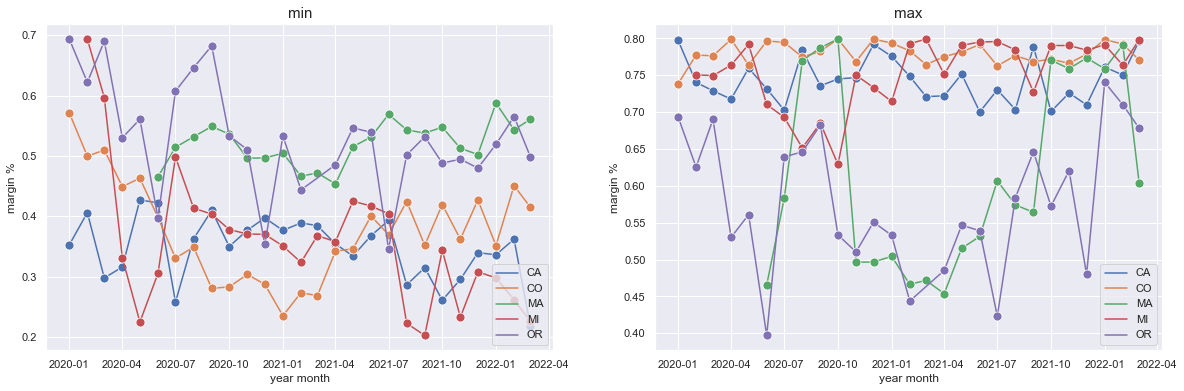

In [406]:
# trimmed pre tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="date", y="min", hue="state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("min", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr, x="date", y="max", hue="state",marker= 'o', markersize=9,ax=ax[1])
ax[1].legend(loc = 4)
ax[1].set_title("max", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
#ax[1].set(ylim=(0.2, 1))
sns.set(rc={'figure.figsize':(20,6)})


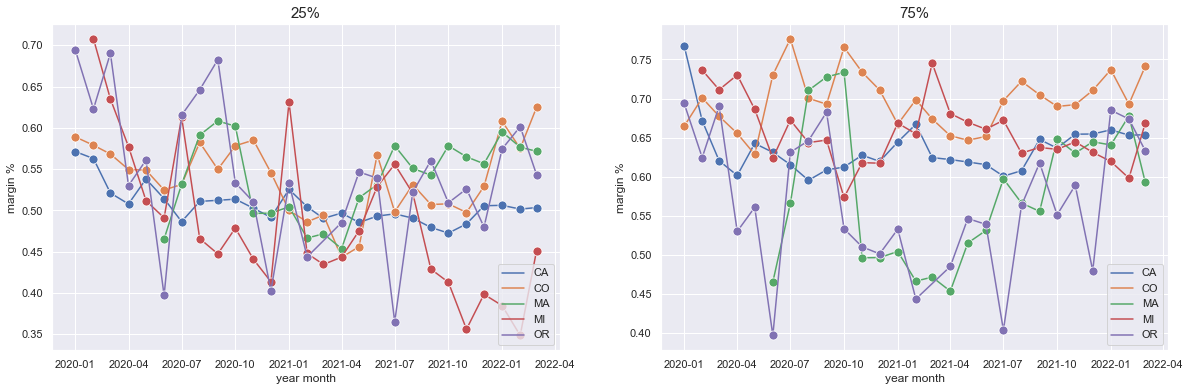

In [407]:
# trimmed pre tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="date", y="25%", hue="state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("25%", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr, x="date", y="75%", hue="state",marker= 'o', markersize=9,ax=ax[1])
ax[1].legend(loc = 4)
ax[1].set_title("75%", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
#ax[1].set(ylim=(0.2, 1))
sns.set(rc={'figure.figsize':(20,6)})


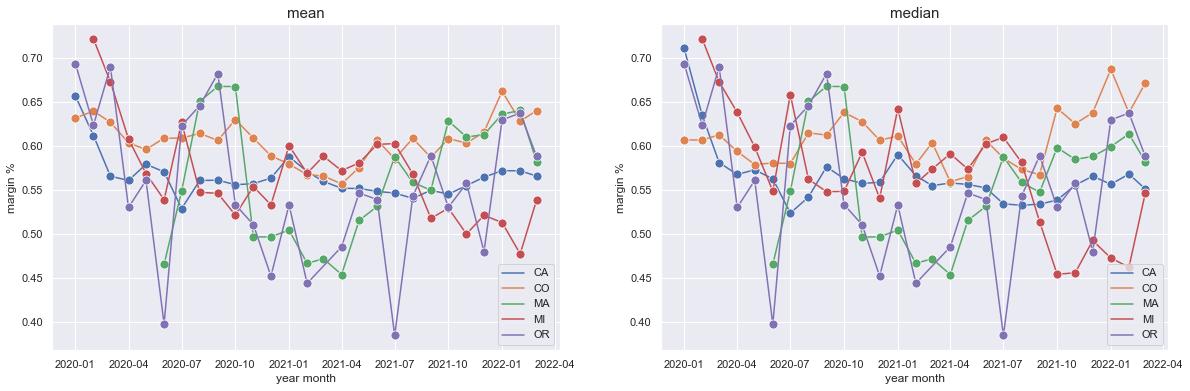

In [408]:
# trimmed pre tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr, x="date", y="mean", hue="state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("mean", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr, x="date", y="50%", hue="state",marker= 'o', markersize=9,ax=ax[1])
ax[1].legend(loc = 4)
ax[1].set_title("median", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
#ax[1].set(ylim=(0.2, 1))
sns.set(rc={'figure.figsize':(20,6)})


In [387]:
margin_distr.to_csv('fh_margin_distr.csv')

In [366]:
#metrc_fh.to_csv('metrc_fh.csv')

In [437]:
pos = pd.read_csv('pos_csv - Sheet1.csv')

In [438]:
pos['date'] = pd.to_datetime(pos['date'])

In [440]:
pos['% Margin w/o Tax'] = pos['% Margin w/o Tax'].astype('float')
pos['Revenue w/o Tax'] = pos['Revenue w/o Tax'].astype('float')


In [441]:
pos[['date','US state','Company identifier']].groupby(['date','US state']).count().unstack().reset_index().fillna(0)

date Company identifier               
US state                            CA   CO   MA   MI
0        2019-05-01                0.0  0.0  0.0  1.0
1        2019-06-01                0.0  0.0  0.0  1.0
2        2019-07-01                0.0  0.0  0.0  1.0
3        2019-08-01                0.0  0.0  0.0  1.0
4        2019-09-01                0.0  0.0  0.0  1.0
5        2019-10-01                0.0  0.0  0.0  1.0
6        2019-11-01                0.0  0.0  0.0  1.0
7        2019-12-01                0.0  0.0  0.0  1.0
8        2020-01-01                2.0  0.0  0.0  2.0
9        2020-02-01                2.0  0.0  0.0  2.0
10       2020-03-01                2.0  0.0  0.0  2.0
11       2020-04-01                2.0  0.0  0.0  2.0
12       2020-05-01                2.0  0.0  0.0  2.0
13       2020-06-01                2.0  0.0  0.0  2.0
14       2020-07-01                2.0  0.0  0.0  2.0
15       2020-08-01                2.0  0.0  0.0  2.0
16       2020-09-01                3.0  0.0  0.0  2.0
17       2020-10-01                3.0  0.0  0.0  2.0
18       2020-11-01                3.0  0.0  0.0  2.0
19       2020-12-01                4.0  1.0  0.0  2.0
20       2021-01-01                9.0  6.0  0.0  4.0
21       2021-02-01               13.0  6.0  0.0  4.0
22       2021-03-01               13.0  7.0  0.0  4.0
23       2021-04-01               14.0  8.0  0.0  4.0
24       2021-05-01               14.0  8.0  0.0  5.0
25       2021-06-01               14.0  9.0  0.0  5.0
26       2021-07-01               14.0  9.0  2.0  7.0
27       2021-08-01               14.0  9.0  2.0  7.0
28       2021-09-01               13.0  9.0  2.0  7.0
29       2021-10-01               14.0  9.0  2.0  7.0
30       2021-11-01               14.0  1.0  2.0  6.0
31       2021-12-01               13.0  1.0  2.0  2.0
32       2022-01-01                8.0  0.0  2.0  2.0
33       2022-02-01                5.0  0.0  0.0  1.0

In [445]:
pos_Rev_change = pos.groupby('Company identifier').apply(lambda df: df.set_index('date').resample('1MS').first()['Revenue w/o Tax'].pct_change()).reset_index()

pos_Rev_change.columns = ['Company identifier','date','rev_change']


In [444]:
pos_Rev_change

,Company identifier,date,Revenue w/o Tax
0,99HT,2021-02-01,NaN
1,99HT,2021-03-01,3.611395
2,99HT,2021-04-01,-0.013218
3,99HT,2021-05-01,-0.028130
4,99HT,2021-06-01,-0.061055
...,...,...,...
283,UHHC,2021-07-01,-0.088491
284,UHHC,2021-08-01,-0.147756
285,UHHC,2021-09-01,-0.037103
286,UHHC,2021-10-01,0.127315


In [446]:
pos_data_all = pos_Rev_change.merge(pos,on = ['Company identifier','date'],how = 'right')

In [448]:
pos_data_all.to_csv('pos_data_all.csv')

In [452]:
margin_distr_pos = pos.groupby(['US state'])['% Margin w/o Tax'].describe().reset_index()

In [453]:
margin_distr_pos


,US state,count,mean,std,min,25%,50%,75%,max
0,CA,201.0,0.535771,0.060898,0.31,0.510,0.54,0.58,0.64
1,CO,83.0,0.459157,0.113859,0.22,0.395,0.44,0.50,0.79
2,MA,14.0,0.457857,0.020448,0.42,0.440,0.47,0.47,0.48
3,MI,97.0,0.472577,0.072691,0.29,0.440,0.49,0.52,0.62


In [430]:
margin_distr_pos = pos.groupby(['US state','date'])['% Margin w/o Tax'].describe().reset_index()
margin_distr_pos['date'] = pd.to_datetime(margin_distr_pos['date'])

In [431]:
margin_distr_pos

,US state,date,count,mean,std,min,25%,50%,75%,max
0,CA,2020-01-01,2.0,0.535000,0.063640,0.49,0.5125,0.535,0.5575,0.58
1,CA,2020-02-01,2.0,0.535000,0.035355,0.51,0.5225,0.535,0.5475,0.56
2,CA,2020-03-01,2.0,0.540000,0.056569,0.50,0.5200,0.540,0.5600,0.58
3,CA,2020-04-01,2.0,0.555000,0.049497,0.52,0.5375,0.555,0.5725,0.59
4,CA,2020-05-01,2.0,0.565000,0.049497,0.53,0.5475,0.565,0.5825,0.60
...,...,...,...,...,...,...,...,...,...,...
75,MI,2021-10-01,7.0,0.498571,0.035322,0.45,0.4750,0.510,0.5200,0.54
76,MI,2021-11-01,6.0,0.443333,0.074476,0.34,0.4200,0.425,0.4750,0.56
77,MI,2021-12-01,2.0,0.430000,0.028284,0.41,0.4200,0.430,0.4400,0.45
78,MI,2022-01-01,2.0,0.500000,0.084853,0.44,0.4700,0.500,0.5300,0.56


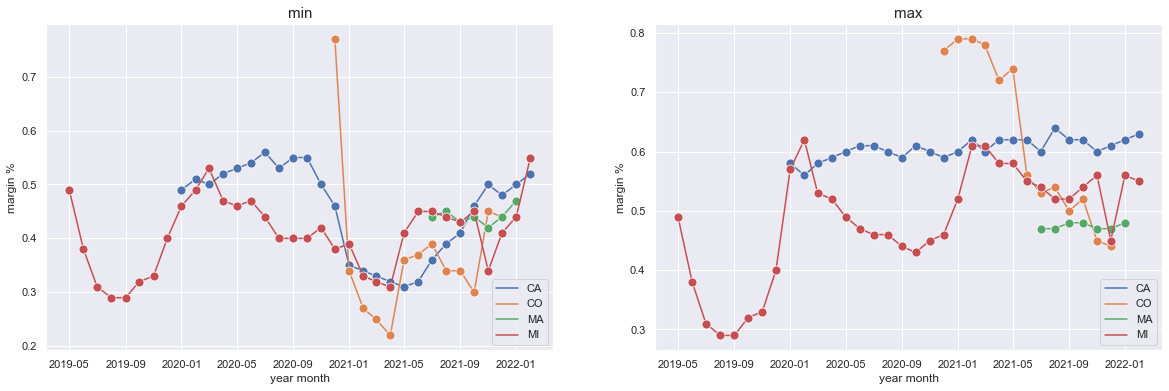

In [432]:
# trimmed pre tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr_pos, x="date", y="min", hue="US state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("min", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr_pos, x="date", y="max", hue="US state",marker= 'o', markersize=9,ax=ax[1])
ax[1].legend(loc = 4)
ax[1].set_title("max", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
#ax[1].set(ylim=(0.2, 1))
sns.set(rc={'figure.figsize':(20,6)})


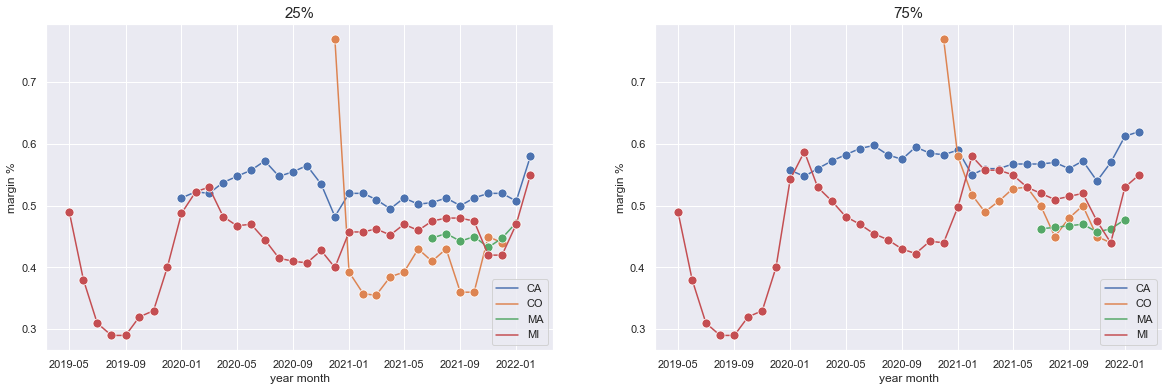

In [433]:
# trimmed pre tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr_pos, x="date", y="25%", hue="US state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("25%", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr_pos, x="date", y="75%", hue="US state",marker= 'o', markersize=9,ax=ax[1])
ax[1].legend(loc = 4)
ax[1].set_title("75%", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
#ax[1].set(ylim=(0.2, 1))
sns.set(rc={'figure.figsize':(20,6)})


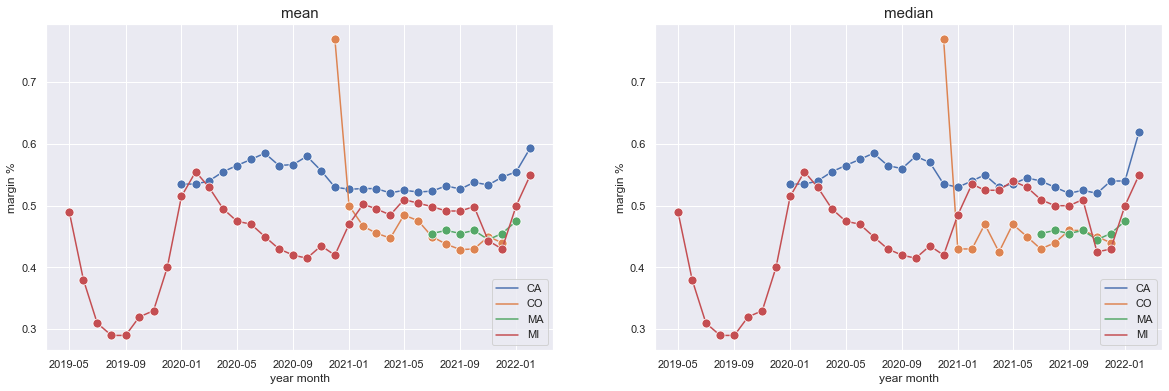

In [434]:
# trimmed pre tax
fig, ax =plt.subplots(1,2)
sns.lineplot(data=margin_distr_pos, x="date", y="mean", hue="US state",marker= 'o', markersize=9,ax=ax[0])
ax[0].legend(loc = 4)
ax[0].set_title("mean", fontsize=15)
ax[0].set_xlabel ("year month")
ax[0].set_ylabel ("margin %")
sns.lineplot(data=margin_distr_pos, x="date", y="50%", hue="US state",marker= 'o', markersize=9,ax=ax[1])
ax[1].legend(loc = 4)
ax[1].set_title("median", fontsize=15)
ax[1].set_xlabel ("year month")
ax[1].set_ylabel ("margin %")
#ax[1].set(ylim=(0.2, 1))
sns.set(rc={'figure.figsize':(20,6)})


# GM$

In [ ]:
import seaborn as sns

## 3M

In [ ]:
df_high_coverage_gm_trim_3m = df_high_coverage[(df_high_coverage['gm$_past_quarter_after_tax'] > 0)&(df_high_coverage['gm$_past_quarter_after_tax'] < 500000)]




In [ ]:
df_high_coverage_gm_trim_3m[['date','gm$_past_quarter_after_tax']].groupby(['date']).quantile(.75)


## 6m

In [ ]:
df_high_coverage_gm_trim_6m = df_high_coverage[(df_high_coverage['gm$_past_2quarters_after_tax'] > 0)&(df_high_coverage['gm$_past_2quarters_after_tax'] < 500000)]




In [ ]:
df_high_coverage_gm_trim_6m[['date','gm$_past_quarter_after_tax']].groupby(['date']).quantile(.75)

## 9M

In [ ]:
df_high_coverage_gm_trim_9m = df_high_coverage[(df_high_coverage['gm$_past_3quarters_after_tax'] > 0)&(df_high_coverage['gm$_past_3quarters_after_tax'] < 500000)]




In [ ]:
df_high_coverage_gm_trim_9m[['date','gm$_past_quarter_after_tax']].groupby(['date']).quantile(.75)

In [ ]:
df_high_coverage_gm_trim = df_high_coverage[(df_high_coverage['margin_$_after_tax'] > 0)&(df_high_coverage['margin_$_after_tax'] < 500000)]

In [ ]:
df_high_coverage['margin_$_after_tax'].quantile(0.9)

In [ ]:
df_high_coverage[df_high_coverage['margin_$_after_tax'] > 800000]

In [ ]:
df_high_coverage_gm_trim.shape[0] / df_high_coverage.shape[0]

In [ ]:
sns.boxplot(df_high_coverage['margin_$_after_tax'])

In [ ]:
df_high_coverage['margin_$_after_tax'].describe()

In [ ]:
df_high_coverage['margin_$_after_tax'].quantile(0.9)

In [ ]:
stats.percentileofscore(df_high_coverage['margin_$_after_tax'],270000, kind='strict')

In [ ]:
plt.hist(df_high_coverage['margin_$_after_tax'],bins = 100)

In [ ]:
df_high_coverage_gm_trim[['date','margin_$_after_tax']].groupby(['date']).quantile(.9)


In [ ]:
df_high_coverage[['date','margin_$_after_tax']].groupby(['date']).quantile(.5)